In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 패키지

In [2]:
!pip install tensorflow
!pip3 install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 505.3 MB 5.6 kB/s 
     |████████████████████████████████| 1.7 MB 35.9 MB/s 
     |████████████████████████████████| 438 kB 26.2 MB/s 
     |████████████████████████████████| 5.8 MB 50.1 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import argparse
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import Lambda, Input, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Conv1DTranspose

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.feature_selection import RFE

# 데이터 전처리

### 추출하여 대체
<p>wav 파일의 길이가 30초로 딱 떨어지지 않기 떄문에 같은 3초 데이터라도 맨 뒤 3초에 대한 특징이 추출되지 않는 문제 발생</p>
➡ wav 파일의 맨 뒤에서 직접 3초 데이터 추출하여 대체

In [ ]:
# 대체 데이터
replace_df = pd.read_csv('/content/drive/MyDrive/기계팀플/table_추가.csv', index_col=0)
# 3초 데이터
data_3 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/features_3_sec.csv')
print('원본 3초 데이터', data_3.shape)
print(data_3['label'].value_counts())

# filename에 장르, 노래 구분을 위한 숫자만 남김
for i in range(len(replace_df)):
  replace_df['filename9'][i] = replace_df['filename9'][i][9:-4]
for i in range(len(data_3)):
  data_3['filename'][i] = data_3['filename'][i][:-4]

# replace_df의 열 이름 data_3과 맞추기
cols = []
for colname in replace_df.columns:
  cols.append(colname[:-1])
replace_df.columns = cols

print("="*50)
data_3 = pd.concat([data_3, replace_df], axis=0)
data_3 = data_3.sort_values(by='filename', ascending=True)
data_3.reset_index(inplace=True, drop=True)
print('대체 3초 데이터', data_3.shape)
print(data_3['label'].value_counts())

원본 3초 데이터 (9990, 60)
blues        1000
jazz         1000
metal        1000
pop          1000
reggae       1000
disco         999
classical     998
hiphop        998
rock          998
country       997
Name: label, dtype: int64
대체 3초 데이터 (10000, 60)
blues        1000
classical    1000
country      1000
disco        1000
hiphop       1000
jazz         1000
metal        1000
pop          1000
reggae       1000
rock         1000
Name: label, dtype: int64


### 생성하여 대체
<p>reggae.00086.wav 파일이 음악이 아닌 잡음으로 구성되어 있는 문제 확인</p>
➡ reggae 음악 100개 중 86번째 음악을 제외한 99개의 음악에 대하여, 3초 데이터의 평균값을 이용해 86번째 음악을 대체

3초 데이터

In [ ]:
# 기존 reggae.00086 관련 데이터 삭제
for i in range(10):
  idx = data_3[data_3['filename'] == 'reggae.00086.'+str(i)].index
  data_3 = data_3.drop(idx)
print(data_3['label'].value_counts())

# reggae 데이터
reggae_df = data_3[data_3['label'] == 'reggae']
for i in range(len(reggae_df)):
  reggae_df['filename'].iloc[i] = reggae_df['filename'].iloc[i][-1]

# reggae 데이터의 3초, 3초, ..., 3초 데이터에 관한 feature 별 평균값 도출
avg_list = []
for i in range(10):
  temp = reggae_df[reggae_df['filename'] == str(i)]
  avg_list.append([])
  for j in range(len(temp.columns)):
    if temp.columns[j] == 'filename' or temp.columns[j] == 'label':
      avg_list[i].append(temp.iloc[i,j])
      continue
    sum = 0
    for k in range(len(temp)):
      sum += temp.iloc[k,j]
    avg_list[i].append(sum/len(temp))
replace_df = pd.DataFrame(avg_list)
replace_df.columns = reggae_df.columns

for i in range(len(replace_df)):
  replace_df['filename'].iloc[i] = 'reggae.00086.'+str(i)
  replace_df['length'].iloc[i] = round(replace_df['length'].iloc[i])

data_3 = pd.concat([data_3, replace_df], axis=0)
data_3.reset_index(inplace=True, drop=True)
print(data_3['label'].value_counts())

blues        1000
classical    1000
country      1000
disco        1000
hiphop       1000
jazz         1000
metal        1000
pop          1000
rock         1000
reggae        990
Name: label, dtype: int64
blues        1000
classical    1000
country      1000
disco        1000
hiphop       1000
jazz         1000
metal        1000
pop          1000
reggae       1000
rock         1000
Name: label, dtype: int64


In [ ]:
data_3.to_csv('/content/drive/MyDrive/기계팀플/Data/features_3_sec_replaced.csv', index=False)

30초 데이터

In [ ]:
# 30초 데이터
data_30 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/features_30_sec.csv')
# 기존 reggae.00086 관련 데이터 삭제
for i in range(10):
  idx = data_30[data_30['filename'] == 'reggae.00086.wav'].index
  data_30 = data_30.drop(idx)
print('원본 30초 데이터', data_30.shape)
print(data_30['label'].value_counts())

# filename에 장르, 노래 구분을 위한 숫자만 남김
for i in range(len(data_30)):
  data_30['filename'].iloc[i] = data_30['filename'].iloc[i][:-4]

# reggae 데이터
reggae_df = data_30[data_30['label'] == 'reggae']
for i in range(len(reggae_df)):
  reggae_df['filename'].iloc[i] = reggae_df['filename'].iloc[i][-5]

# reggae 데이터의 30초 데이터에 관한 feature 별 평균값 도출
avg_list = []
for i in range(len(reggae_df.columns)):
  if reggae_df.columns[i] == 'filename':
    avg_list.append(reggae_df.iloc[i,0])
    continue
  elif reggae_df.columns[i] == 'label':
    avg_list.append(reggae_df.iloc[i,-1])
    continue
  sum = 0
  for k in range(len(reggae_df)):
    sum += reggae_df.iloc[k,i]
  avg_list.append(sum/len(reggae_df))
replace_df = pd.DataFrame(avg_list).T
replace_df.columns = reggae_df.columns
replace_df['filename'].iloc[0] = 'reggae.00086'
replace_df['length'].iloc[0] = 661794

data_30 = pd.concat([data_30, replace_df], axis=0)
data_30.reset_index(inplace=True, drop=True)
print(data_30['label'].value_counts())

원본 30초 데이터 (999, 60)
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
rock         100
reggae        99
Name: label, dtype: int64
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64


In [ ]:
data_30.to_csv('/content/drive/MyDrive/기계팀플/Data/features_30_sec_replaced.csv', index=False)

# 3초, 30초 데이터 병합

In [ ]:
data_30 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/features_30_sec_replaced.csv')
data_3 = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/features_3_sec_replaced.csv')
data_3 = data_3.dropna()
data_30 = data_30.dropna()
print(data_30.shape, data_3.shape)

# # filename 같은 음악 관련 데이터 같은 이름 갖도록 수정
# for i in range(len(data_3)):
#   data_3['filename'][i] = data_3['filename'][i][:-6]
# for i in range(len(data_30)):
#   data_30['filename'][i] = data_30['filename'][i][:-4]

(1000, 60) (10000, 60)


In [ ]:
# data_3 같은 음악 행 가로로 붙이기
music_count = 10
cols = []
for i in range(music_count):
  for j in range(len(data_3.columns)):
    cols.append(data_3.columns[j]+str(i))

df = pd.DataFrame(columns=cols)

for i in range(len(data_3)):
  if i%10 == 0:
    if i != 0:
      temp = temp.T
      temp.columns = df.columns
      df = pd.concat([df, temp])
      df.reset_index(inplace=True, drop=True)
    temp = pd.DataFrame(data_3.iloc[i,:])
    temp.columns = [0]
  else:
    temp = pd.concat([temp, data_3.iloc[i,:]])
temp = temp.T
temp.columns = df.columns
df = pd.concat([df, temp])  
df.reset_index(inplace=True, drop=True)

df = df.dropna()
df = df.sort_values(by='filename0', ascending=True)
df.reset_index(inplace=True, drop=True)

# data_30을 data_3에 가로로 붙이기
cols = []
for col in data_30.columns:
    cols.append(col+str(10))
data_30.columns = cols

result_df = pd.concat([df, data_30], axis=1)

# filename, length, label 하나만 남기기
final_cols = list(result_df.columns)
print(len(final_cols))

remove_cols = ['filename', 'length', 'label']
for col in remove_cols:
  for i in range(11):
    if i == 0:
      idx = final_cols.index(col+str(i))
      final_cols[idx] = col
    else:
      final_cols.remove(col+str(i))
      result_df = result_df.drop(columns=col+str(i))

print(len(final_cols))  # 3개(filename, length, label)씩 10개(장르), 총 30개 줄어듦
result_df.columns = final_cols

660
630


In [ ]:
result_df.head()

,filename,length,chroma_stft_mean0,chroma_stft_var0,rms_mean0,rms_var0,spectral_centroid_mean0,spectral_centroid_var0,spectral_bandwidth_mean0,spectral_bandwidth_var0,...,mfcc16_mean10,mfcc16_var10,mfcc17_mean10,mfcc17_var10,mfcc18_mean10,mfcc18_var10,mfcc19_mean10,mfcc19_var10,mfcc20_mean10,mfcc20_var10
0,blues.00000.0,66149.0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,blues.00001.0,66149.0,0.402401,0.09034,0.093024,0.003876,1279.182242,406513.816744,1921.306192,196573.441648,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,blues.00002.0,66149.0,0.366614,0.090509,0.152206,0.002467,1676.978191,433761.847841,1794.856236,56792.9825,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,blues.00003.0,66149.0,0.369137,0.100557,0.140007,0.008827,860.252136,86352.958353,1375.235919,74735.002549,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,blues.00004.0,66149.0,0.307888,0.088962,0.080472,0.000657,1544.038015,141191.203107,1577.30253,38990.828473,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [ ]:
# result_df.to_csv('/content/drive/MyDrive/기계팀플/vae_final/concat_features.csv')

# 차원축소

## 함수 준비
참고: https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter8-vae/vae-mlp-mnist-8.1.1.py

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mlp_plot"):

    encoder, decoder = models
    x_test, y_test = data
    xmin = ymin = -4
    xmax = ymax = +4
    os.makedirs(model_name, exist_ok=True)

    # display a 2D plot of the digit classes in the latent space
    z, _, _ = encoder.predict(x_test,
                              batch_size=batch_size)
    plt.figure(figsize=(12, 10))

    # axes x and y ranges
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])

    # subsample to reduce density of points on the plot
    z = z[0::2]
    y_test = y_test[0::2]
    plt.scatter(z[:, 0], z[:, 1], marker="")
    for i, digit in enumerate(y_test):
        axes.annotate(digit, (z[i, 0], z[i, 1]))
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## PCA

In [5]:
general_path = '/content/drive/MyDrive/기계팀플/Data'
data = pd.read_csv(f'{general_path}/features_3_sec.csv')
data = data.iloc[0:, 1:] 
features = data.columns[:-1]
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
x = data.iloc[:, :-1]
x.shape

(9990, 58)

In [7]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(data.iloc[:, :-1])
scaled_x.shape

(9990, 58)

In [8]:
y = data.iloc[:, -1]
y.shape

(9990,)

In [9]:
for i in range(1, len(features)+1):
  pca = PCA(n_components=i)
  pcs = pca.fit_transform(scaled_x)
  pca_data = pd.DataFrame(data=pcs, columns = ['pc'+str(j) for j in range(i)])
  print(i, '번째 성분이 설명 가능한 분산(반올림)', round(pca.explained_variance_ratio_[-1]*100), '%')
  print('변수', i, '개가 설명 가능한 분산(반올림)', round(sum(pca.explained_variance_ratio_)*100), '%')
  print()

1 번째 성분이 설명 가능한 분산(반올림) 20 %
변수 1 개가 설명 가능한 분산(반올림) 20 %

2 번째 성분이 설명 가능한 분산(반올림) 14 %
변수 2 개가 설명 가능한 분산(반올림) 34 %

3 번째 성분이 설명 가능한 분산(반올림) 10 %
변수 3 개가 설명 가능한 분산(반올림) 44 %

4 번째 성분이 설명 가능한 분산(반올림) 7 %
변수 4 개가 설명 가능한 분산(반올림) 51 %

5 번째 성분이 설명 가능한 분산(반올림) 4 %
변수 5 개가 설명 가능한 분산(반올림) 55 %

6 번째 성분이 설명 가능한 분산(반올림) 4 %
변수 6 개가 설명 가능한 분산(반올림) 59 %

7 번째 성분이 설명 가능한 분산(반올림) 3 %
변수 7 개가 설명 가능한 분산(반올림) 62 %

8 번째 성분이 설명 가능한 분산(반올림) 3 %
변수 8 개가 설명 가능한 분산(반올림) 64 %

9 번째 성분이 설명 가능한 분산(반올림) 2 %
변수 9 개가 설명 가능한 분산(반올림) 67 %

10 번째 성분이 설명 가능한 분산(반올림) 2 %
변수 10 개가 설명 가능한 분산(반올림) 69 %

11 번째 성분이 설명 가능한 분산(반올림) 2 %
변수 11 개가 설명 가능한 분산(반올림) 71 %

12 번째 성분이 설명 가능한 분산(반올림) 2 %
변수 12 개가 설명 가능한 분산(반올림) 72 %

13 번째 성분이 설명 가능한 분산(반올림) 2 %
변수 13 개가 설명 가능한 분산(반올림) 74 %

14 번째 성분이 설명 가능한 분산(반올림) 1 %
변수 14 개가 설명 가능한 분산(반올림) 76 %

15 번째 성분이 설명 가능한 분산(반올림) 1 %
변수 15 개가 설명 가능한 분산(반올림) 77 %

16 번째 성분이 설명 가능한 분산(반올림) 1 %
변수 16 개가 설명 가능한 분산(반올림) 78 %

17 번째 성분이 설명 가능한 분산(반올림) 1 %
변수 17 개가 설명 가능한 분산(반올림) 79 %

18 번째 성분이 설명

In [10]:
# 변수 설명 분산 그래프
pca = PCA()
pca.fit(scaled_x)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

## VAE_1DCNN

In [11]:
data = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/concat_features.csv')
print(data.shape)
data.head()

(1000, 630)


,filename,length,chroma_stft_mean0,chroma_stft_var0,rms_mean0,rms_var0,spectral_centroid_mean0,spectral_centroid_var0,spectral_bandwidth_mean0,spectral_bandwidth_var0,...,mfcc16_mean10,mfcc16_var10,mfcc17_mean10,mfcc17_var10,mfcc18_mean10,mfcc18_var10,mfcc19_mean10,mfcc19_var10,mfcc20_mean10,mfcc20_var10
0,blues.00000,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,blues.00001,66149,0.292987,0.082145,0.094924,0.003031,1373.437553,210606.446462,1929.319087,165808.594240,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,blues.00002,66149,0.299589,0.083030,0.170790,0.001917,1396.794527,81945.617374,1517.311972,92242.679953,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,blues.00003,66149,0.387297,0.092417,0.149871,0.005382,1061.389626,128482.413202,1665.487663,123692.389644,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,blues.00004,66149,0.281015,0.081816,0.069944,0.001954,1378.200657,89462.647415,1548.954870,52114.315750,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [12]:
# 가로세로 짝수로 맞추기 위해 11개 열 추가
data['filename'] = 0
temp = pd.DataFrame(data['filename'])
temp.columns = ['padding']
for i in range(11):
  data['padding'+str(i)] = temp
data.head()

,filename,length,chroma_stft_mean0,chroma_stft_var0,rms_mean0,rms_var0,spectral_centroid_mean0,spectral_centroid_var0,spectral_bandwidth_mean0,spectral_bandwidth_var0,...,padding1,padding2,padding3,padding4,padding5,padding6,padding7,padding8,padding9,padding10
0,0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,0,0,0,0,0,0,0,0,0,0
1,0,66149,0.292987,0.082145,0.094924,0.003031,1373.437553,210606.446462,1929.319087,165808.594240,...,0,0,0,0,0,0,0,0,0,0
2,0,66149,0.299589,0.083030,0.170790,0.001917,1396.794527,81945.617374,1517.311972,92242.679953,...,0,0,0,0,0,0,0,0,0,0
3,0,66149,0.387297,0.092417,0.149871,0.005382,1061.389626,128482.413202,1665.487663,123692.389644,...,0,0,0,0,0,0,0,0,0,0
4,0,66149,0.281015,0.081816,0.069944,0.001954,1378.200657,89462.647415,1548.954870,52114.315750,...,0,0,0,0,0,0,0,0,0,0


In [13]:
x = data.drop(columns=['label'])
y = data['label']

# 정규화(0 ~ 1)
scaler = MinMaxScaler()
scaler.fit(x) #MinMaxScaler 모델에 x_train_df 데이터 적용 (최소값, 최대값 계산)
x = scaler.transform(x)
x.shape

(1000, 640)

In [14]:
# train, test 8:2로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)

x_train = np.reshape(x_train, [-1, 640, 1])
x_test = np.reshape(x_test, [-1, 640, 1])
print(x_train.shape, x_test.shape)

(800, 640, 1) (200, 640, 1)


In [ ]:
def VAE_1DCNN(latent_dim=2, epoch=50):
  input_shape = (640, 1)
  batch_size = 128
  kernel_size = 3
  filters = 16
  # latent_dim = 5    # 최적의 차원 구하기
  epochs = 50

  # VAE model = encoder + decoder
  # build encoder model
  inputs = Input(shape=input_shape, name='encoder_input')
  x = inputs
  for i in range(2):
      filters *= 2
      x = Conv1D(filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                padding='same')(x)

  # shape info needed to build decoder model
  shape = K.int_shape(x)

  # generate latent vector Q(z|X)
  x = Flatten()(x)
  x = Dense(16, activation='relu')(x)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary 
  # with the TensorFlow backend
  z = Lambda(sampling,
            output_shape=(latent_dim,), 
            name='z')([z_mean, z_log_var])

  # instantiate encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  # encoder.summary()
  plot_model(encoder,
            to_file='vae_cnn_encoder.png', 
            show_shapes=True)
  
  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(shape[1] * shape[2],
            activation='relu')(latent_inputs)
  x = Reshape((shape[1], shape[2]))(x)
  # x = Dense(shape[1] * shape[2] * shape[3],
  #           activation='relu')(latent_inputs)
  # x = Reshape((shape[1], shape[2], shape[3]))(x)

  for i in range(2):
      x = Conv1DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          padding='same')(x)
      filters //= 2

  outputs = Conv1DTranspose(filters=1,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  # decoder.summary()
  plot_model(decoder,
            to_file='vae_cnn_decoder.png', 
            show_shapes=True)

  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])   # encoder(inputs)[2] ==  z == latent vector?
  vae = Model(inputs, outputs, name='vae')

  parser = argparse.ArgumentParser()
  help_ = "Load tf model trained weights"
  parser.add_argument("-w", "--weights", help=help_)
  help_ = "Use binary cross entropy instead of mse (default)"
  parser.add_argument("--bce", help=help_, action='store_true')
  args = parser.parse_args('')
  models = (encoder, decoder)
  data = (x_test, y_test)

  # VAE loss = mse_loss or xent_loss + kl_loss
  if args.bce:
      reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                K.flatten(outputs))
  else:
      reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

  # reconstruction_loss *= image_size * image_size
  # reconstruction_loss *= row_size * col_size
  reconstruction_loss *= 640
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='rmsprop')
  # vae.summary()
  plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

  save_dir = "vae_cnn_weights"
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  if args.weights:
      filepath = os.path.join(save_dir, args.weights)
      vae = vae.load_weights(filepath)
  else:
      # train the autoencoder
      history = vae.fit(x_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))
      filepath = os.path.join(save_dir, 'vae_cnn_mnist.tf')
      vae.save_weights(filepath)

  plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

  return history

latent_dim = 2
Epoch 1/50
7/7 [==============================] - 6s 321ms/step - loss: 51.9248 - val_loss: 40.2344
Epoch 2/50
7/7 [==============================] - 2s 234ms/step - loss: 36.3176 - val_loss: 31.1807
Epoch 3/50
7/7 [==============================] - 2s 228ms/step - loss: 26.5445 - val_loss: 20.3933
Epoch 4/50
7/7 [==============================] - 2s 229ms/step - loss: 18.9057 - val_loss: 17.1029
Epoch 5/50
7/7 [==============================] - 2s 225ms/step - loss: 16.3235 - val_loss: 15.6849
Epoch 6/50
7/7 [==============================] - 2s 224ms/step - loss: 15.1085 - val_loss: 14.8999
Epoch 7/50
7/7 [==============================] - 2s 221ms/step - loss: 14.3710 - val_loss: 14.3673
Epoch 8/50
7/7 [==============================] - 2s 218ms/step - loss: 13.6361 - val_loss: 13.5493
Epoch 9/50
7/7 [==============================] - 2s 222ms/step - loss: 13.0372 - val_loss: 13.4206
Epoch 10/50
7/7 [==============================] - 2s 218ms/step - loss: 12.7236 - va

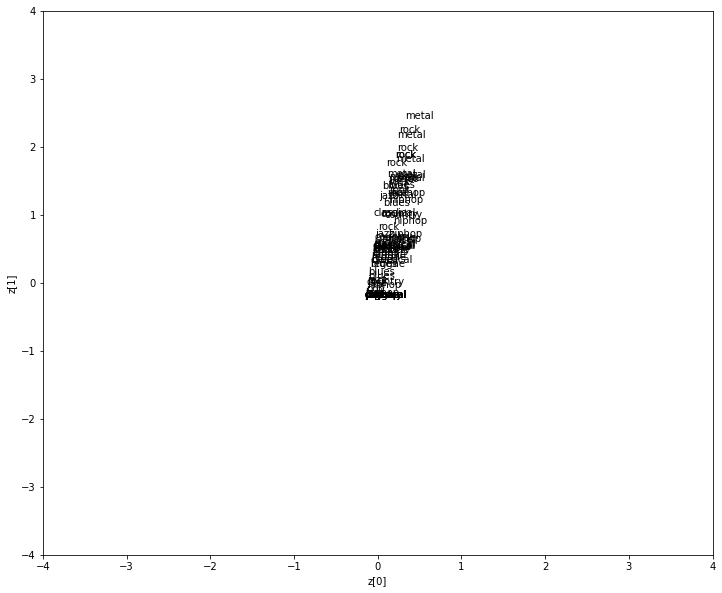

latent_dim = 3
Epoch 1/50
7/7 [==============================] - 4s 310ms/step - loss: 50.3833 - val_loss: 36.6780
Epoch 2/50
7/7 [==============================] - 2s 244ms/step - loss: 31.4812 - val_loss: 25.1107
Epoch 3/50
7/7 [==============================] - 2s 245ms/step - loss: 21.7964 - val_loss: 19.2757
Epoch 4/50
7/7 [==============================] - 2s 237ms/step - loss: 18.1725 - val_loss: 17.1005
Epoch 5/50
7/7 [==============================] - 2s 235ms/step - loss: 16.0655 - val_loss: 15.6303
Epoch 6/50
7/7 [==============================] - 2s 235ms/step - loss: 14.8329 - val_loss: 14.5196
Epoch 7/50
7/7 [==============================] - 2s 260ms/step - loss: 13.9497 - val_loss: 13.9636
Epoch 8/50
7/7 [==============================] - 2s 235ms/step - loss: 13.3089 - val_loss: 13.5126
Epoch 9/50
7/7 [==============================] - 2s 237ms/step - loss: 12.8635 - val_loss: 12.8055
Epoch 10/50
7/7 [==============================] - 2s 236ms/step - loss: 12.5886 - va

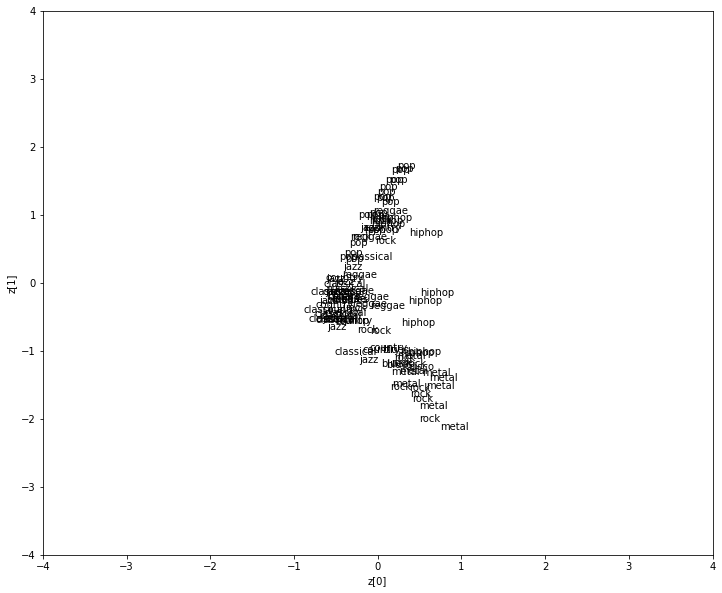

latent_dim = 4
Epoch 1/50
7/7 [==============================] - 5s 283ms/step - loss: 51.1918 - val_loss: 38.8601
Epoch 2/50
7/7 [==============================] - 2s 225ms/step - loss: 33.6975 - val_loss: 25.9822
Epoch 3/50
7/7 [==============================] - 2s 218ms/step - loss: 22.3144 - val_loss: 19.7291
Epoch 4/50
7/7 [==============================] - 2s 221ms/step - loss: 18.5335 - val_loss: 18.6352
Epoch 5/50
7/7 [==============================] - 2s 222ms/step - loss: 16.6297 - val_loss: 16.2640
Epoch 6/50
7/7 [==============================] - 2s 216ms/step - loss: 15.5085 - val_loss: 15.8547
Epoch 7/50
7/7 [==============================] - 2s 216ms/step - loss: 14.8371 - val_loss: 14.5701
Epoch 8/50
7/7 [==============================] - 2s 221ms/step - loss: 14.3211 - val_loss: 14.2790
Epoch 9/50
7/7 [==============================] - 2s 219ms/step - loss: 13.5427 - val_loss: 13.9017
Epoch 10/50
7/7 [==============================] - 2s 224ms/step - loss: 12.9409 - va

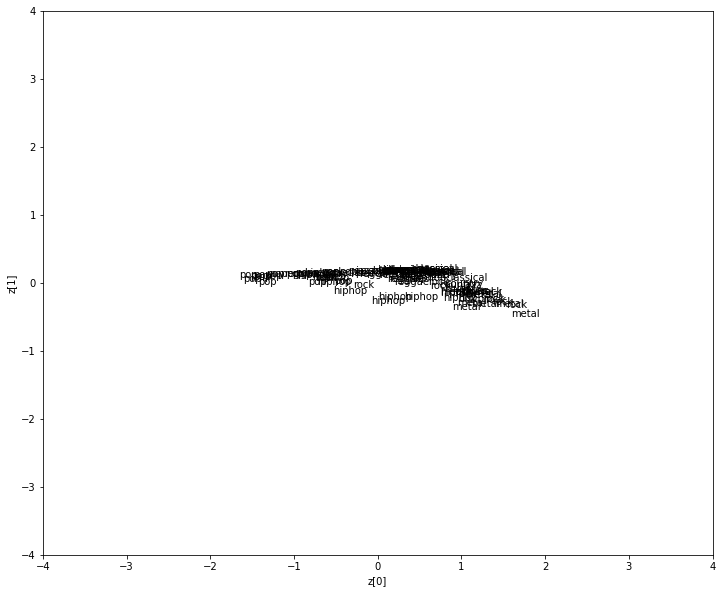

latent_dim = 5
Epoch 1/50
7/7 [==============================] - 4s 299ms/step - loss: 54.0448 - val_loss: 44.8051
Epoch 2/50
7/7 [==============================] - 2s 235ms/step - loss: 33.2678 - val_loss: 21.8771
Epoch 3/50
7/7 [==============================] - 2s 247ms/step - loss: 20.2767 - val_loss: 18.9495
Epoch 4/50
7/7 [==============================] - 2s 251ms/step - loss: 17.6218 - val_loss: 17.1546
Epoch 5/50
7/7 [==============================] - 2s 247ms/step - loss: 16.2011 - val_loss: 15.6586
Epoch 6/50
7/7 [==============================] - 2s 244ms/step - loss: 15.4516 - val_loss: 15.0196
Epoch 7/50
7/7 [==============================] - 2s 238ms/step - loss: 14.7352 - val_loss: 14.8020
Epoch 8/50
7/7 [==============================] - 2s 240ms/step - loss: 14.0943 - val_loss: 14.5134
Epoch 9/50
7/7 [==============================] - 2s 246ms/step - loss: 13.6509 - val_loss: 13.7119
Epoch 10/50
7/7 [==============================] - 2s 246ms/step - loss: 13.2896 - va

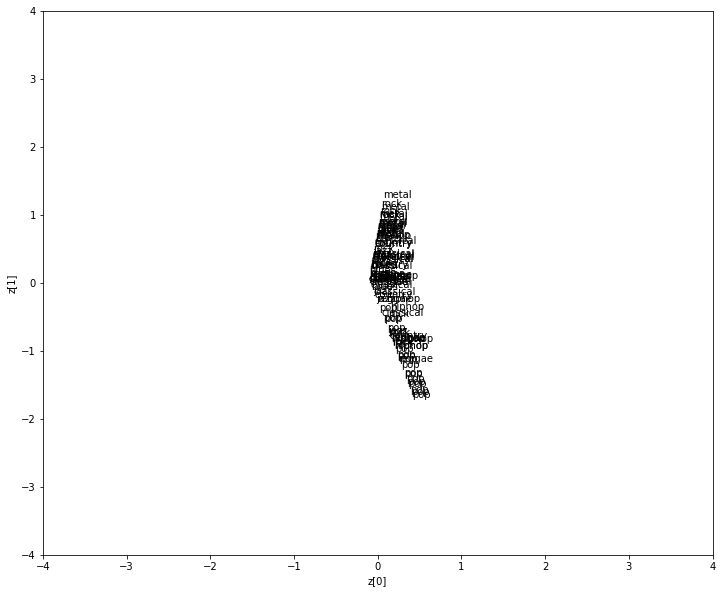

latent_dim = 6
Epoch 1/50
7/7 [==============================] - 4s 300ms/step - loss: 50.7725 - val_loss: 38.5331
Epoch 2/50
7/7 [==============================] - 2s 243ms/step - loss: 34.9628 - val_loss: 29.2350
Epoch 3/50
7/7 [==============================] - 2s 226ms/step - loss: 24.9998 - val_loss: 20.2399
Epoch 4/50
7/7 [==============================] - 2s 228ms/step - loss: 18.6082 - val_loss: 18.3550
Epoch 5/50
7/7 [==============================] - 2s 234ms/step - loss: 16.8653 - val_loss: 16.5732
Epoch 6/50
7/7 [==============================] - 2s 273ms/step - loss: 15.4098 - val_loss: 15.6289
Epoch 7/50
7/7 [==============================] - 2s 271ms/step - loss: 14.6695 - val_loss: 14.9319
Epoch 8/50
7/7 [==============================] - 2s 269ms/step - loss: 13.9012 - val_loss: 14.3890
Epoch 9/50
7/7 [==============================] - 2s 260ms/step - loss: 13.5337 - val_loss: 13.9546
Epoch 10/50
7/7 [==============================] - 2s 263ms/step - loss: 13.1417 - va

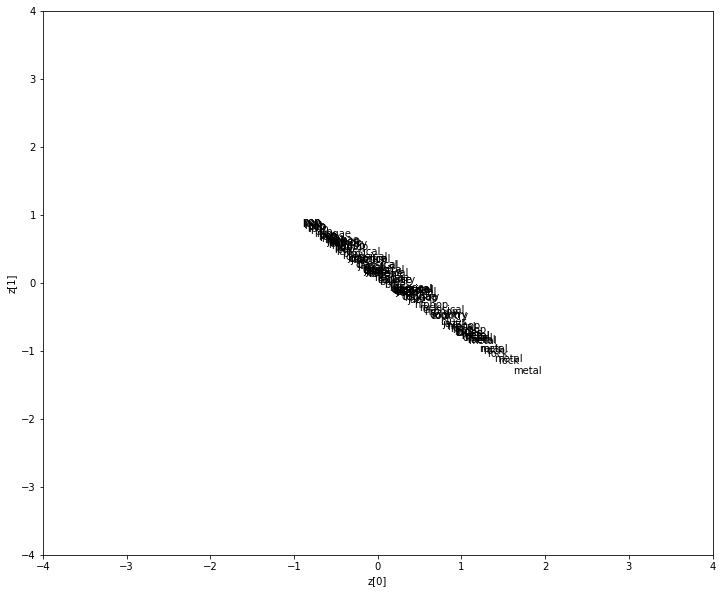

latent_dim = 7
Epoch 1/50
7/7 [==============================] - 5s 373ms/step - loss: 48.3035 - val_loss: 35.2616
Epoch 2/50
7/7 [==============================] - 2s 247ms/step - loss: 32.4750 - val_loss: 26.1799
Epoch 3/50
7/7 [==============================] - 2s 248ms/step - loss: 22.4712 - val_loss: 18.9501
Epoch 4/50
7/7 [==============================] - 2s 277ms/step - loss: 18.0779 - val_loss: 17.0283
Epoch 5/50
7/7 [==============================] - 2s 268ms/step - loss: 16.1122 - val_loss: 15.7680
Epoch 6/50
7/7 [==============================] - 2s 250ms/step - loss: 15.0369 - val_loss: 14.9425
Epoch 7/50
7/7 [==============================] - 2s 237ms/step - loss: 14.4856 - val_loss: 14.8002
Epoch 8/50
7/7 [==============================] - 2s 235ms/step - loss: 13.8334 - val_loss: 13.9356
Epoch 9/50
7/7 [==============================] - 2s 230ms/step - loss: 13.5775 - val_loss: 14.0173
Epoch 10/50
7/7 [==============================] - 2s 229ms/step - loss: 12.8119 - va

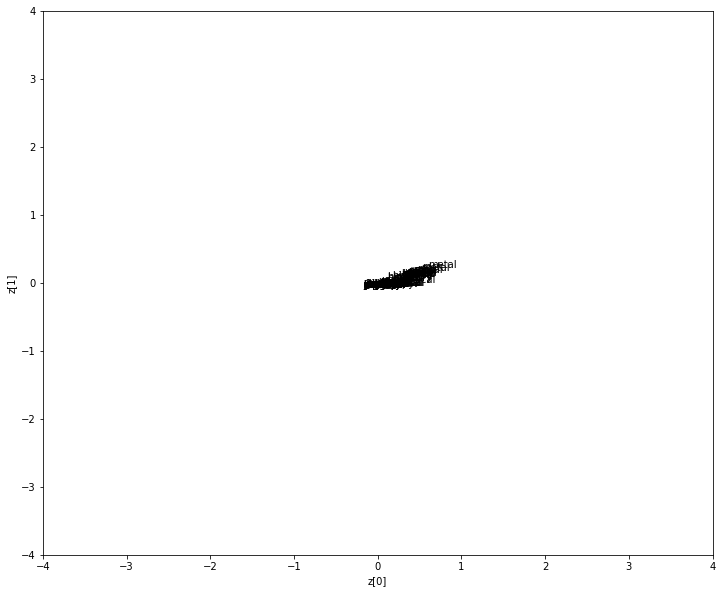

latent_dim = 8
Epoch 1/50
7/7 [==============================] - 4s 309ms/step - loss: 53.1427 - val_loss: 42.5669
Epoch 2/50
7/7 [==============================] - 2s 235ms/step - loss: 35.8657 - val_loss: 27.0008
Epoch 3/50
7/7 [==============================] - 2s 228ms/step - loss: 22.3526 - val_loss: 19.0507
Epoch 4/50
7/7 [==============================] - 2s 237ms/step - loss: 18.1239 - val_loss: 17.6371
Epoch 5/50
7/7 [==============================] - 2s 229ms/step - loss: 16.0803 - val_loss: 15.8818
Epoch 6/50
7/7 [==============================] - 2s 231ms/step - loss: 15.0532 - val_loss: 15.3302
Epoch 7/50
7/7 [==============================] - 2s 227ms/step - loss: 14.7818 - val_loss: 15.2374
Epoch 8/50
7/7 [==============================] - 2s 228ms/step - loss: 13.9841 - val_loss: 14.4029
Epoch 9/50
7/7 [==============================] - 2s 230ms/step - loss: 13.4560 - val_loss: 14.0964
Epoch 10/50
7/7 [==============================] - 2s 231ms/step - loss: 13.2437 - va

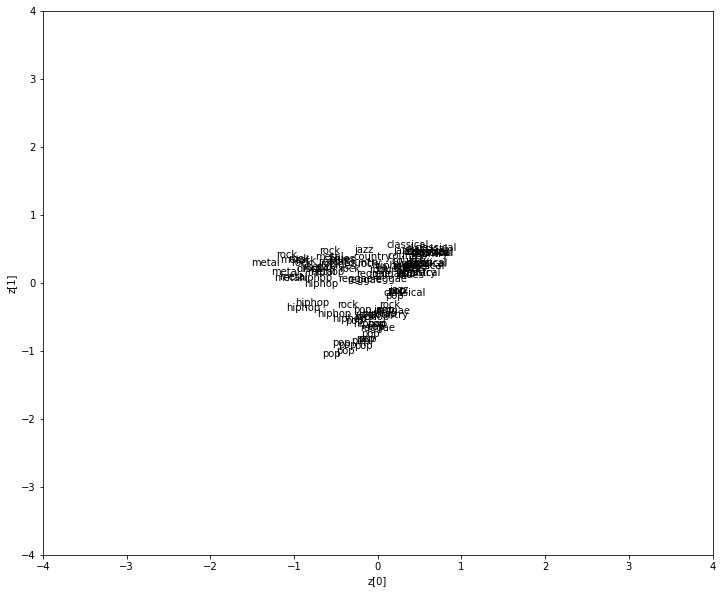

latent_dim = 9
Epoch 1/50
7/7 [==============================] - 5s 298ms/step - loss: 47.4151 - val_loss: 34.5161
Epoch 2/50
7/7 [==============================] - 2s 232ms/step - loss: 30.5757 - val_loss: 23.4532
Epoch 3/50
7/7 [==============================] - 2s 234ms/step - loss: 20.7208 - val_loss: 18.9675
Epoch 4/50
7/7 [==============================] - 2s 223ms/step - loss: 17.4910 - val_loss: 16.3836
Epoch 5/50
7/7 [==============================] - 2s 223ms/step - loss: 15.6768 - val_loss: 16.1059
Epoch 6/50
7/7 [==============================] - 2s 224ms/step - loss: 15.1760 - val_loss: 14.9288
Epoch 7/50
7/7 [==============================] - 2s 223ms/step - loss: 14.4818 - val_loss: 14.3329
Epoch 8/50
7/7 [==============================] - 2s 221ms/step - loss: 13.7303 - val_loss: 14.0829
Epoch 9/50
7/7 [==============================] - 2s 224ms/step - loss: 13.3209 - val_loss: 13.4359
Epoch 10/50
7/7 [==============================] - 2s 239ms/step - loss: 12.9145 - va

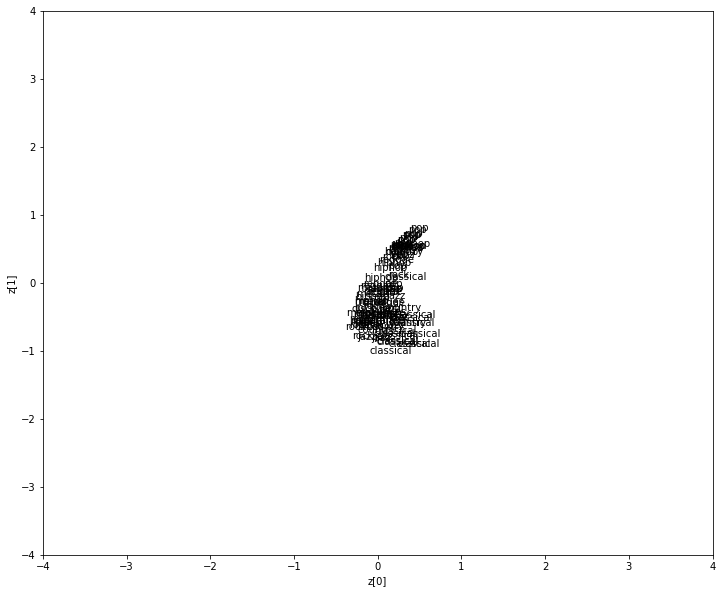

latent_dim = 10
Epoch 1/50
7/7 [==============================] - 4s 287ms/step - loss: 50.5042 - val_loss: 38.0304
Epoch 2/50
7/7 [==============================] - 2s 226ms/step - loss: 33.5954 - val_loss: 27.3584
Epoch 3/50
7/7 [==============================] - 2s 224ms/step - loss: 23.7490 - val_loss: 19.6974
Epoch 4/50
7/7 [==============================] - 2s 223ms/step - loss: 18.3844 - val_loss: 17.5890
Epoch 5/50
7/7 [==============================] - 2s 222ms/step - loss: 16.7069 - val_loss: 16.4907
Epoch 6/50
7/7 [==============================] - 2s 224ms/step - loss: 15.9043 - val_loss: 15.4576
Epoch 7/50
7/7 [==============================] - 2s 220ms/step - loss: 14.7643 - val_loss: 14.9411
Epoch 8/50
7/7 [==============================] - 2s 220ms/step - loss: 14.1522 - val_loss: 14.5353
Epoch 9/50
7/7 [==============================] - 2s 219ms/step - loss: 13.8421 - val_loss: 14.4563
Epoch 10/50
7/7 [==============================] - 2s 224ms/step - loss: 13.4990 - v

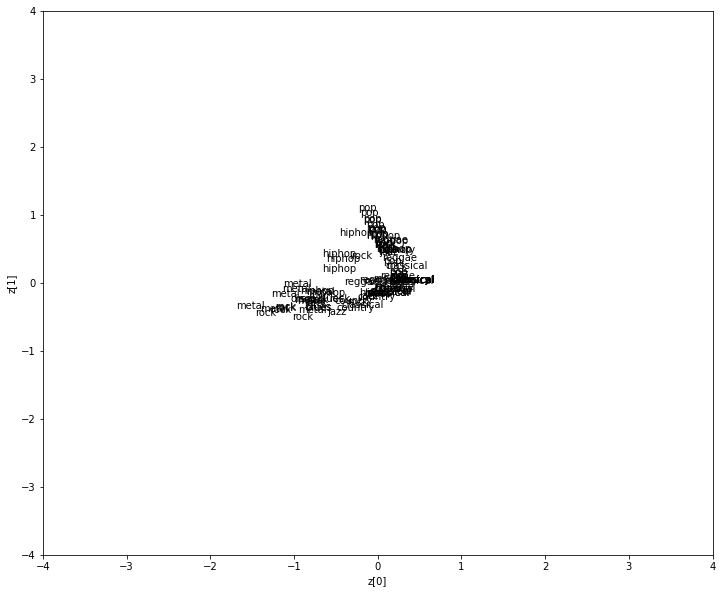

latent_dim = 11
Epoch 1/50
7/7 [==============================] - 4s 295ms/step - loss: 49.2653 - val_loss: 36.2641
Epoch 2/50
7/7 [==============================] - 2s 224ms/step - loss: 32.2584 - val_loss: 25.8134
Epoch 3/50
7/7 [==============================] - 2s 224ms/step - loss: 22.0285 - val_loss: 19.4757
Epoch 4/50
7/7 [==============================] - 2s 232ms/step - loss: 17.4336 - val_loss: 17.2795
Epoch 5/50
7/7 [==============================] - 2s 224ms/step - loss: 16.2920 - val_loss: 15.9792
Epoch 6/50
7/7 [==============================] - 2s 225ms/step - loss: 15.0163 - val_loss: 15.1254
Epoch 7/50
7/7 [==============================] - 2s 226ms/step - loss: 14.5600 - val_loss: 14.5652
Epoch 8/50
7/7 [==============================] - 2s 229ms/step - loss: 13.8879 - val_loss: 13.9340
Epoch 9/50
7/7 [==============================] - 2s 221ms/step - loss: 13.4125 - val_loss: 13.7497
Epoch 10/50
7/7 [==============================] - 2s 221ms/step - loss: 12.9039 - v

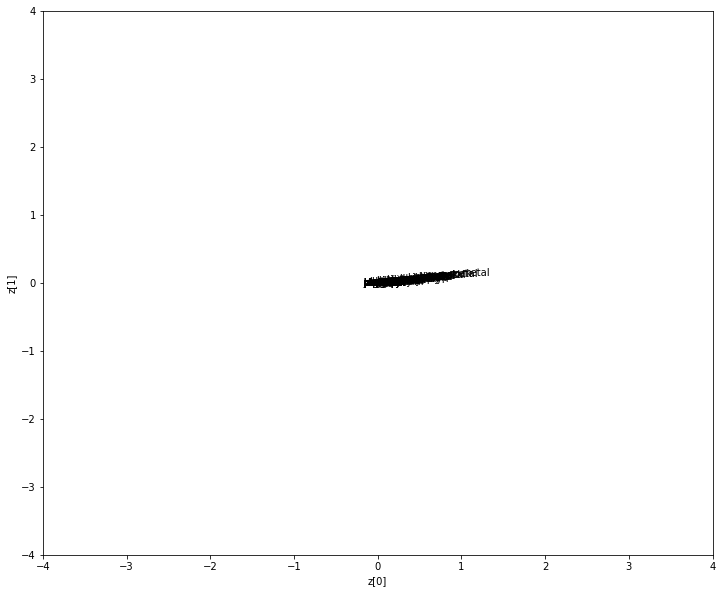

latent_dim = 12
Epoch 1/50
7/7 [==============================] - 4s 296ms/step - loss: 49.5714 - val_loss: 36.8100
Epoch 2/50
7/7 [==============================] - 2s 225ms/step - loss: 33.3752 - val_loss: 27.0841
Epoch 3/50
7/7 [==============================] - 2s 226ms/step - loss: 22.9359 - val_loss: 19.1001
Epoch 4/50
7/7 [==============================] - 2s 220ms/step - loss: 17.8869 - val_loss: 17.0459
Epoch 5/50
7/7 [==============================] - 2s 227ms/step - loss: 16.1531 - val_loss: 16.0399
Epoch 6/50
7/7 [==============================] - 2s 231ms/step - loss: 15.1546 - val_loss: 15.2054
Epoch 7/50
7/7 [==============================] - 2s 224ms/step - loss: 14.4118 - val_loss: 14.9087
Epoch 8/50
7/7 [==============================] - 2s 226ms/step - loss: 13.8578 - val_loss: 13.7727
Epoch 9/50
7/7 [==============================] - 2s 228ms/step - loss: 13.3495 - val_loss: 13.5740
Epoch 10/50
7/7 [==============================] - 2s 231ms/step - loss: 13.1129 - v

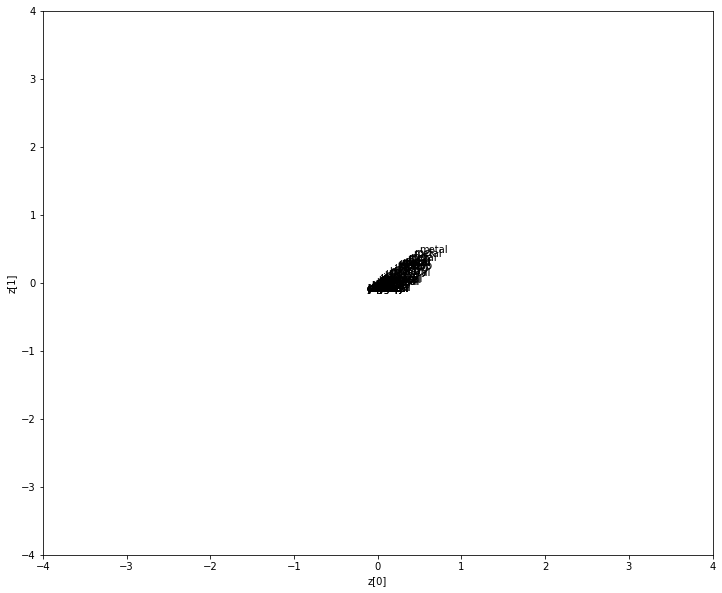

latent_dim = 13
Epoch 1/50
7/7 [==============================] - 4s 294ms/step - loss: 53.5257 - val_loss: 42.7609
Epoch 2/50
7/7 [==============================] - 2s 235ms/step - loss: 35.4982 - val_loss: 26.2408
Epoch 3/50
7/7 [==============================] - 2s 229ms/step - loss: 22.2040 - val_loss: 18.9336
Epoch 4/50
7/7 [==============================] - 2s 229ms/step - loss: 18.0168 - val_loss: 17.3640
Epoch 5/50
7/7 [==============================] - 2s 239ms/step - loss: 16.5534 - val_loss: 16.1512
Epoch 6/50
7/7 [==============================] - 2s 229ms/step - loss: 15.5514 - val_loss: 15.4651
Epoch 7/50
7/7 [==============================] - 2s 231ms/step - loss: 14.9189 - val_loss: 14.5074
Epoch 8/50
7/7 [==============================] - 2s 225ms/step - loss: 14.0483 - val_loss: 14.0889
Epoch 9/50
7/7 [==============================] - 2s 234ms/step - loss: 13.8566 - val_loss: 14.0262
Epoch 10/50
7/7 [==============================] - 2s 227ms/step - loss: 13.4752 - v

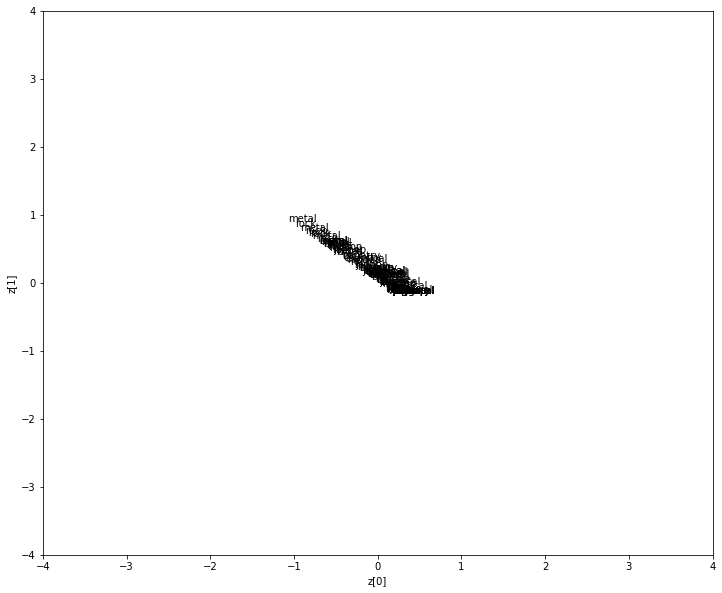

latent_dim = 14
Epoch 1/50
7/7 [==============================] - 4s 280ms/step - loss: 49.8413 - val_loss: 36.5272
Epoch 2/50
7/7 [==============================] - 2s 225ms/step - loss: 34.1967 - val_loss: 30.3093
Epoch 3/50
7/7 [==============================] - 2s 226ms/step - loss: 26.0482 - val_loss: 19.9275
Epoch 4/50
7/7 [==============================] - 2s 233ms/step - loss: 18.5602 - val_loss: 17.4759
Epoch 5/50
7/7 [==============================] - 2s 228ms/step - loss: 16.2772 - val_loss: 15.8769
Epoch 6/50
7/7 [==============================] - 2s 227ms/step - loss: 15.2103 - val_loss: 14.8771
Epoch 7/50
7/7 [==============================] - 2s 223ms/step - loss: 14.8353 - val_loss: 14.4009
Epoch 8/50
7/7 [==============================] - 2s 224ms/step - loss: 13.9897 - val_loss: 14.2389
Epoch 9/50
7/7 [==============================] - 2s 224ms/step - loss: 13.6976 - val_loss: 13.8218
Epoch 10/50
7/7 [==============================] - 2s 224ms/step - loss: 13.0107 - v

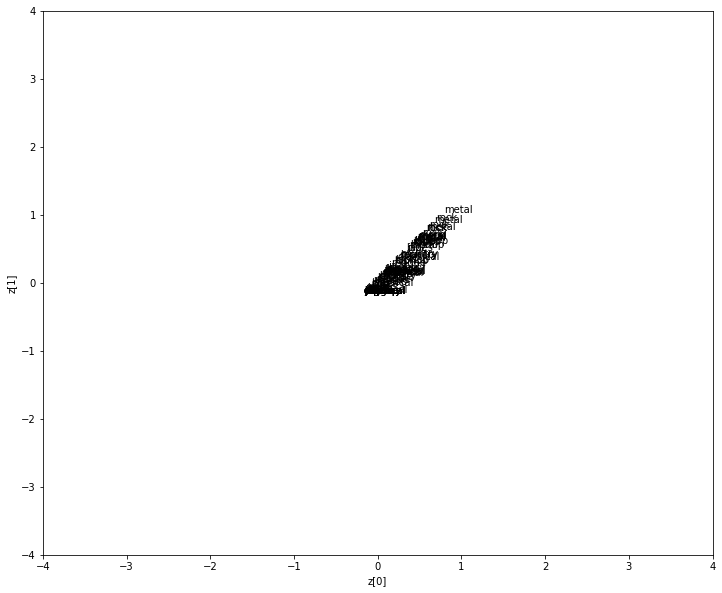

latent_dim = 15
Epoch 1/50
7/7 [==============================] - 4s 285ms/step - loss: 48.8123 - val_loss: 34.6144
Epoch 2/50
7/7 [==============================] - 2s 227ms/step - loss: 29.3299 - val_loss: 21.3378
Epoch 3/50
7/7 [==============================] - 2s 225ms/step - loss: 19.2939 - val_loss: 18.0623
Epoch 4/50
7/7 [==============================] - 2s 226ms/step - loss: 16.8585 - val_loss: 16.8879
Epoch 5/50
7/7 [==============================] - 2s 225ms/step - loss: 15.7712 - val_loss: 16.7697
Epoch 6/50
7/7 [==============================] - 2s 225ms/step - loss: 14.9514 - val_loss: 14.8269
Epoch 7/50
7/7 [==============================] - 2s 228ms/step - loss: 14.1934 - val_loss: 14.2141
Epoch 8/50
7/7 [==============================] - 2s 228ms/step - loss: 13.9856 - val_loss: 14.6530
Epoch 9/50
7/7 [==============================] - 2s 228ms/step - loss: 13.3100 - val_loss: 13.4862
Epoch 10/50
7/7 [==============================] - 2s 230ms/step - loss: 12.9355 - v

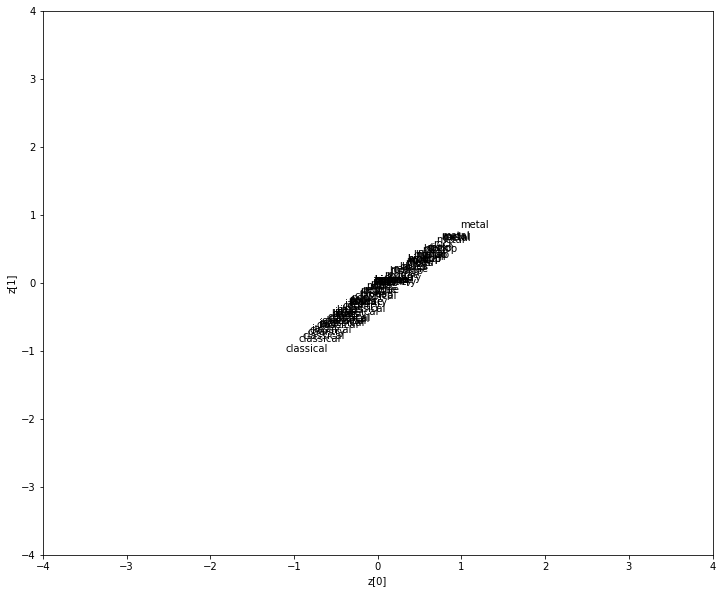

latent_dim = 16
Epoch 1/50
7/7 [==============================] - 4s 295ms/step - loss: 49.6482 - val_loss: 36.1250
Epoch 2/50
7/7 [==============================] - 2s 228ms/step - loss: 31.9451 - val_loss: 25.9794
Epoch 3/50
7/7 [==============================] - 2s 227ms/step - loss: 21.8437 - val_loss: 19.5530
Epoch 4/50
7/7 [==============================] - 2s 230ms/step - loss: 17.7388 - val_loss: 17.2961
Epoch 5/50
7/7 [==============================] - 2s 226ms/step - loss: 16.1567 - val_loss: 15.7083
Epoch 6/50
7/7 [==============================] - 2s 232ms/step - loss: 14.9611 - val_loss: 14.7829
Epoch 7/50
7/7 [==============================] - 2s 224ms/step - loss: 14.7458 - val_loss: 15.1082
Epoch 8/50
7/7 [==============================] - 2s 229ms/step - loss: 13.8715 - val_loss: 14.1702
Epoch 9/50
7/7 [==============================] - 2s 224ms/step - loss: 13.6054 - val_loss: 13.8162
Epoch 10/50
7/7 [==============================] - 2s 226ms/step - loss: 12.9863 - v

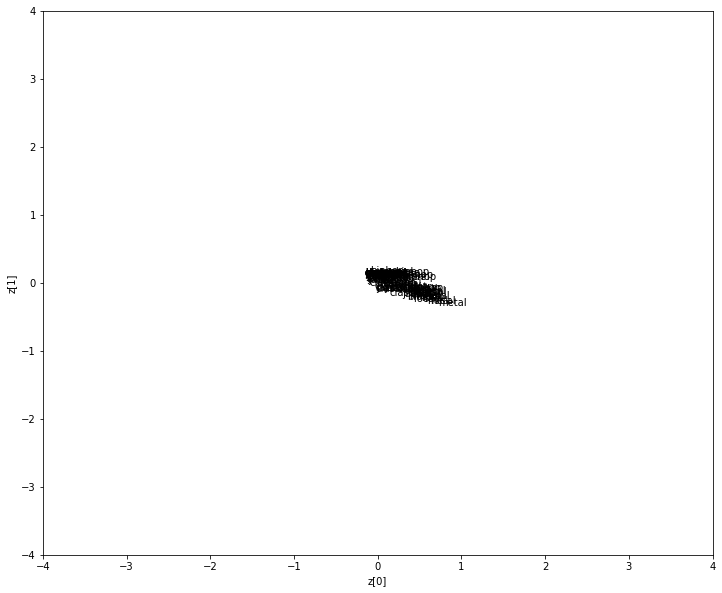

latent_dim = 17
Epoch 1/50
7/7 [==============================] - 4s 296ms/step - loss: 52.5989 - val_loss: 40.6326
Epoch 2/50
7/7 [==============================] - 2s 228ms/step - loss: 33.7278 - val_loss: 24.6981
Epoch 3/50
7/7 [==============================] - 2s 230ms/step - loss: 21.6280 - val_loss: 18.7623
Epoch 4/50
7/7 [==============================] - 2s 226ms/step - loss: 17.6478 - val_loss: 17.4540
Epoch 5/50
7/7 [==============================] - 2s 222ms/step - loss: 16.0140 - val_loss: 16.0157
Epoch 6/50
7/7 [==============================] - 2s 233ms/step - loss: 15.1685 - val_loss: 15.4629
Epoch 7/50
7/7 [==============================] - 2s 228ms/step - loss: 14.5628 - val_loss: 14.6215
Epoch 8/50
7/7 [==============================] - 2s 229ms/step - loss: 13.8563 - val_loss: 14.0245
Epoch 9/50
7/7 [==============================] - 2s 224ms/step - loss: 13.4420 - val_loss: 13.7483
Epoch 10/50
7/7 [==============================] - 2s 232ms/step - loss: 13.3161 - v

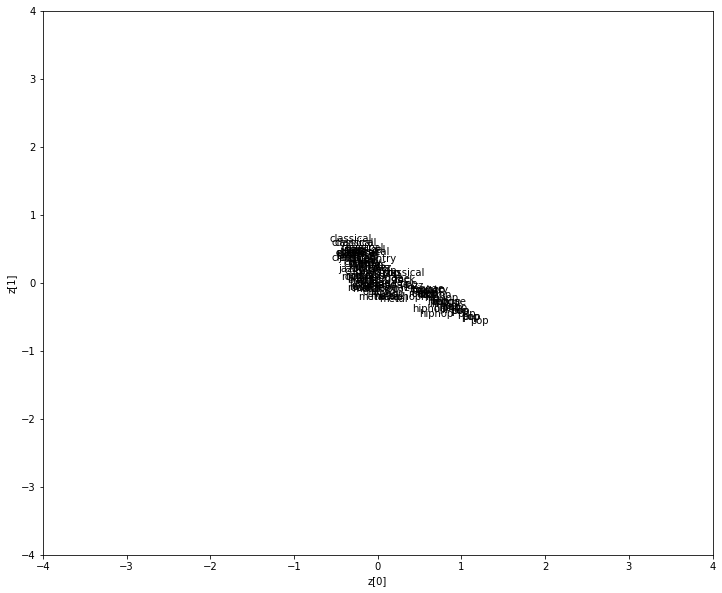

latent_dim = 18
Epoch 1/50
7/7 [==============================] - 4s 292ms/step - loss: 51.3705 - val_loss: 38.5911
Epoch 2/50
7/7 [==============================] - 2s 228ms/step - loss: 31.7417 - val_loss: 22.1211
Epoch 3/50
7/7 [==============================] - 2s 228ms/step - loss: 19.9605 - val_loss: 18.7338
Epoch 4/50
7/7 [==============================] - 2s 235ms/step - loss: 17.3855 - val_loss: 17.4853
Epoch 5/50
7/7 [==============================] - 2s 225ms/step - loss: 16.2337 - val_loss: 16.2761
Epoch 6/50
7/7 [==============================] - 2s 225ms/step - loss: 15.2650 - val_loss: 15.5818
Epoch 7/50
7/7 [==============================] - 2s 227ms/step - loss: 14.8759 - val_loss: 15.0004
Epoch 8/50
7/7 [==============================] - 2s 234ms/step - loss: 14.2197 - val_loss: 14.5560
Epoch 9/50
7/7 [==============================] - 2s 223ms/step - loss: 13.8228 - val_loss: 13.8571
Epoch 10/50
7/7 [==============================] - 2s 223ms/step - loss: 13.3504 - v

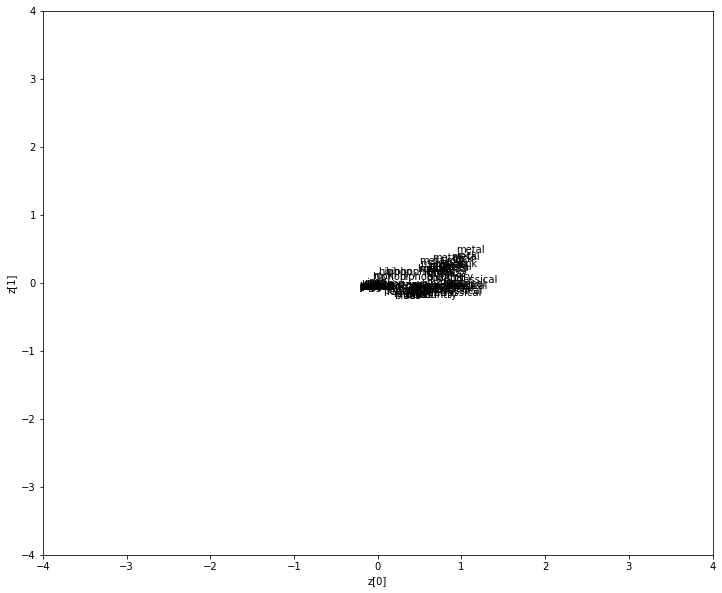

latent_dim = 19
Epoch 1/50
7/7 [==============================] - 4s 285ms/step - loss: 49.5702 - val_loss: 35.7978
Epoch 2/50
7/7 [==============================] - 2s 227ms/step - loss: 30.0999 - val_loss: 21.8902
Epoch 3/50
7/7 [==============================] - 2s 225ms/step - loss: 19.8161 - val_loss: 18.0729
Epoch 4/50
7/7 [==============================] - 2s 225ms/step - loss: 16.6381 - val_loss: 16.7722
Epoch 5/50
7/7 [==============================] - 2s 229ms/step - loss: 15.6481 - val_loss: 15.3572
Epoch 6/50
7/7 [==============================] - 2s 225ms/step - loss: 14.6755 - val_loss: 14.6428
Epoch 7/50
7/7 [==============================] - 2s 230ms/step - loss: 14.0507 - val_loss: 14.3571
Epoch 8/50
7/7 [==============================] - 2s 228ms/step - loss: 13.5381 - val_loss: 13.7796
Epoch 9/50
7/7 [==============================] - 2s 235ms/step - loss: 13.3122 - val_loss: 13.4430
Epoch 10/50
7/7 [==============================] - 2s 226ms/step - loss: 12.8301 - v

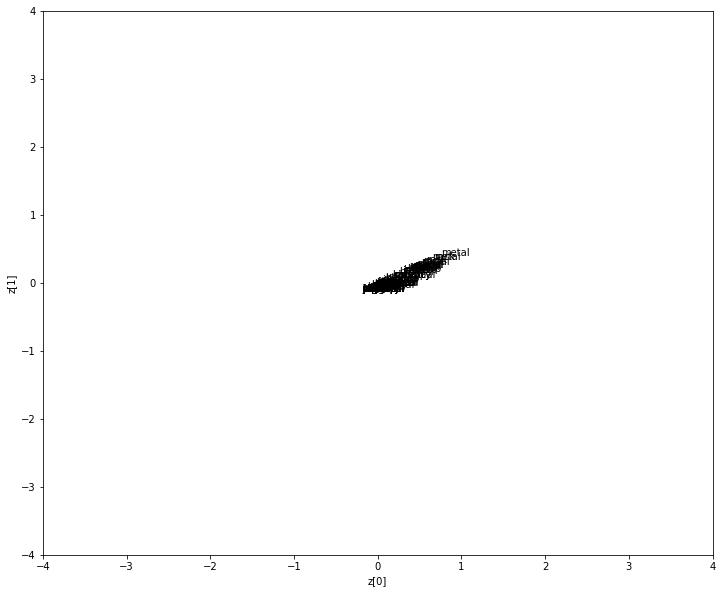

latent_dim = 20
Epoch 1/50
7/7 [==============================] - 5s 388ms/step - loss: 48.6748 - val_loss: 33.7228
Epoch 2/50
7/7 [==============================] - 3s 388ms/step - loss: 26.9669 - val_loss: 20.5013
Epoch 3/50
7/7 [==============================] - 2s 359ms/step - loss: 19.0372 - val_loss: 17.7727
Epoch 4/50
7/7 [==============================] - 2s 298ms/step - loss: 16.7940 - val_loss: 16.7303
Epoch 5/50
7/7 [==============================] - 2s 275ms/step - loss: 16.3118 - val_loss: 15.9523
Epoch 6/50
7/7 [==============================] - 2s 282ms/step - loss: 15.4473 - val_loss: 15.2528
Epoch 7/50
7/7 [==============================] - 2s 281ms/step - loss: 14.6776 - val_loss: 15.1117
Epoch 8/50
7/7 [==============================] - 2s 281ms/step - loss: 14.5984 - val_loss: 14.2917
Epoch 9/50
7/7 [==============================] - 2s 271ms/step - loss: 13.9156 - val_loss: 15.1224
Epoch 10/50
7/7 [==============================] - 2s 240ms/step - loss: 13.7203 - v

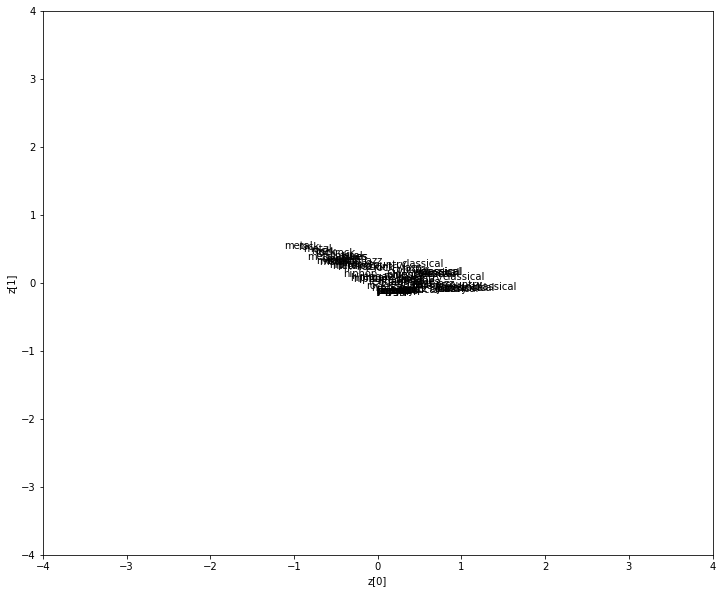

In [ ]:
hist_2d = []
for i in range(2, 21):
  print('latent_dim =', i)
  history = VAE_1DCNN(latent_dim=i)
  hist_2d.append(history)
  print("="*50)

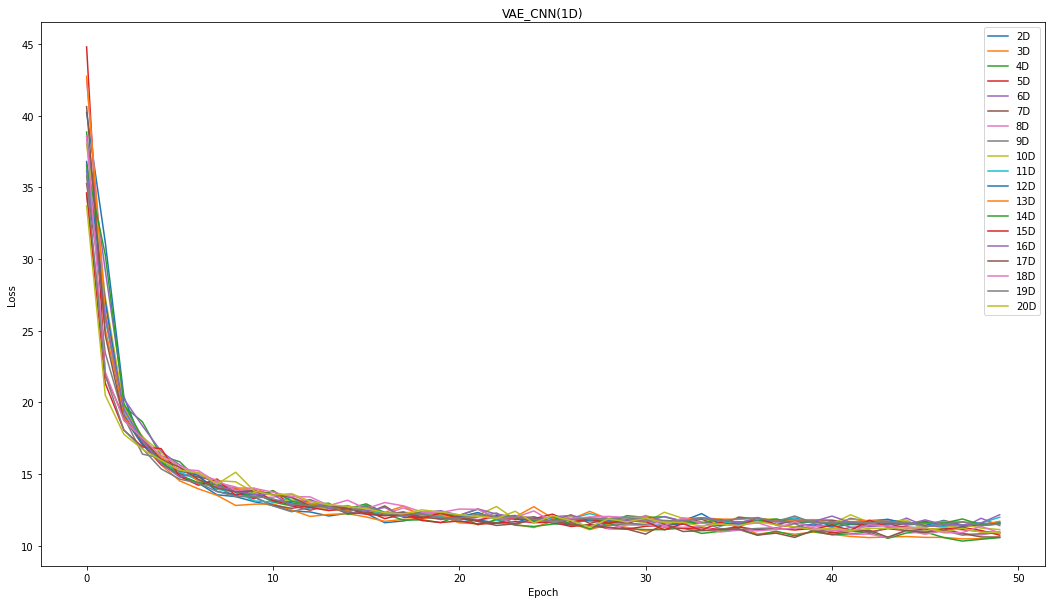

In [ ]:
plt.figure(figsize=(18,10))
# loss 시각화
for i in range(len(hist_2d)):
  plt.plot(hist_2d[i].history['val_loss'])
plt.title('VAE_CNN(1D)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([str(i)+'D' for i in range(2, 21)], loc='upper right')
plt.show()

## VAE_2DCNN

In [15]:
data = pd.read_csv('/content/drive/MyDrive/기계팀플/Data/concat_features.csv')
print(data.shape)
data.head()

(1000, 630)


,filename,length,chroma_stft_mean0,chroma_stft_var0,rms_mean0,rms_var0,spectral_centroid_mean0,spectral_centroid_var0,spectral_bandwidth_mean0,spectral_bandwidth_var0,...,mfcc16_mean10,mfcc16_var10,mfcc17_mean10,mfcc17_var10,mfcc18_mean10,mfcc18_var10,mfcc19_mean10,mfcc19_var10,mfcc20_mean10,mfcc20_var10
0,blues.00000,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,blues.00001,66149,0.292987,0.082145,0.094924,0.003031,1373.437553,210606.446462,1929.319087,165808.594240,...,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,blues.00002,66149,0.299589,0.083030,0.170790,0.001917,1396.794527,81945.617374,1517.311972,92242.679953,...,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,blues.00003,66149,0.387297,0.092417,0.149871,0.005382,1061.389626,128482.413202,1665.487663,123692.389644,...,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,blues.00004,66149,0.281015,0.081816,0.069944,0.001954,1378.200657,89462.647415,1548.954870,52114.315750,...,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [16]:
# 가로세로 짝수로 맞추기 위해 11개 열 추가
data['filename'] = 0
temp = pd.DataFrame(data['filename'])
temp.columns = ['padding']
for i in range(11):
  data['padding'+str(i)] = temp
data.head()

,filename,length,chroma_stft_mean0,chroma_stft_var0,rms_mean0,rms_var0,spectral_centroid_mean0,spectral_centroid_var0,spectral_bandwidth_mean0,spectral_bandwidth_var0,...,padding1,padding2,padding3,padding4,padding5,padding6,padding7,padding8,padding9,padding10
0,0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,0,0,0,0,0,0,0,0,0,0
1,0,66149,0.292987,0.082145,0.094924,0.003031,1373.437553,210606.446462,1929.319087,165808.594240,...,0,0,0,0,0,0,0,0,0,0
2,0,66149,0.299589,0.083030,0.170790,0.001917,1396.794527,81945.617374,1517.311972,92242.679953,...,0,0,0,0,0,0,0,0,0,0
3,0,66149,0.387297,0.092417,0.149871,0.005382,1061.389626,128482.413202,1665.487663,123692.389644,...,0,0,0,0,0,0,0,0,0,0
4,0,66149,0.281015,0.081816,0.069944,0.001954,1378.200657,89462.647415,1548.954870,52114.315750,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# x = data.drop(columns=['filename', 'label'])
x = data.drop(columns=['label'])
y = data['label']

# 정규화(0 ~ 1)
scaler = MinMaxScaler()
scaler.fit(x) #MinMaxScaler 모델에 x_train_df 데이터 적용 (최소값, 최대값 계산)
x = scaler.transform(x)
x.shape

(1000, 640)

In [18]:
# train, test 8:2로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)

# 640 = 2^7 * 5^1
row_size = 20
col_size = 32
x_train = np.reshape(x_train, [-1, row_size, col_size, 1])
x_test = np.reshape(x_test, [-1, row_size, col_size, 1])
print(x_train.shape, x_test.shape)

(800, 20, 32, 1) (200, 20, 32, 1)


In [ ]:
def VAE_2DCNN(latent_dim=2, epoch=50):
  input_shape = (row_size, col_size, 1)
  batch_size = 128
  kernel_size = 3
  filters = 16
  # latent_dim = 5    # 최적의 차원 구하기
  epochs = 50

  # VAE model = encoder + decoder
  # build encoder model
  inputs = Input(shape=input_shape, name='encoder_input')
  x = inputs
  for i in range(2):
      filters *= 2
      x = Conv2D(filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                strides=2,
                padding='same')(x)

  # shape info needed to build decoder model
  shape = K.int_shape(x)

  # generate latent vector Q(z|X)
  x = Flatten()(x)
  x = Dense(16, activation='relu')(x)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  # use reparameterization trick to push the sampling out as input
  # note that "output_shape" isn't necessary 
  # with the TensorFlow backend
  z = Lambda(sampling,
            output_shape=(latent_dim,), 
            name='z')([z_mean, z_log_var])

  # instantiate encoder model
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  # encoder.summary()
  plot_model(encoder,
            to_file='vae_cnn_encoder.png', 
            show_shapes=True)
  
  # build decoder model
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(shape[1] * shape[2] * shape[3],
            activation='relu')(latent_inputs)
  x = Reshape((shape[1], shape[2], shape[3]))(x)

  for i in range(2):
      x = Conv2DTranspose(filters=filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          padding='same')(x)
      filters //= 2

  outputs = Conv2DTranspose(filters=1,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            name='decoder_output')(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  # decoder.summary()
  plot_model(decoder,
            to_file='vae_cnn_decoder.png', 
            show_shapes=True)

  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])   # encoder(inputs)[2] ==  z == latent vector?
  vae = Model(inputs, outputs, name='vae')

  parser = argparse.ArgumentParser()
  help_ = "Load tf model trained weights"
  parser.add_argument("-w", "--weights", help=help_)
  help_ = "Use binary cross entropy instead of mse (default)"
  parser.add_argument("--bce", help=help_, action='store_true')
  args = parser.parse_args('')
  models = (encoder, decoder)
  data = (x_test, y_test)

  # VAE loss = mse_loss or xent_loss + kl_loss
  if args.bce:
      reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                K.flatten(outputs))
  else:
      reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

  # reconstruction_loss *= image_size * image_size
  reconstruction_loss *= row_size * col_size
  kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='rmsprop')
  # vae.summary()
  plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

  save_dir = "vae_cnn_weights"
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  if args.weights:
      filepath = os.path.join(save_dir, args.weights)
      vae = vae.load_weights(filepath)
  else:
      # train the autoencoder
      history = vae.fit(x_train,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(x_test, None))
      filepath = os.path.join(save_dir, 'vae_cnn_mnist.tf')
      vae.save_weights(filepath)

  plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

  return history

latent_dim = 2
Epoch 1/50
7/7 [==============================] - 3s 245ms/step - loss: 45.8667 - val_loss: 35.7416
Epoch 2/50
7/7 [==============================] - 1s 201ms/step - loss: 34.4427 - val_loss: 32.2735
Epoch 3/50
7/7 [==============================] - 1s 200ms/step - loss: 31.8943 - val_loss: 29.5413
Epoch 4/50
7/7 [==============================] - 1s 207ms/step - loss: 28.6187 - val_loss: 26.2206
Epoch 5/50
7/7 [==============================] - 1s 200ms/step - loss: 24.4065 - val_loss: 22.8698
Epoch 6/50
7/7 [==============================] - 1s 206ms/step - loss: 21.7160 - val_loss: 20.9471
Epoch 7/50
7/7 [==============================] - 1s 200ms/step - loss: 19.8559 - val_loss: 19.6734
Epoch 8/50
7/7 [==============================] - 1s 198ms/step - loss: 19.0835 - val_loss: 18.8831
Epoch 9/50
7/7 [==============================] - 1s 200ms/step - loss: 17.7104 - val_loss: 17.8903
Epoch 10/50
7/7 [==============================] - 1s 201ms/step - loss: 16.9440 - va

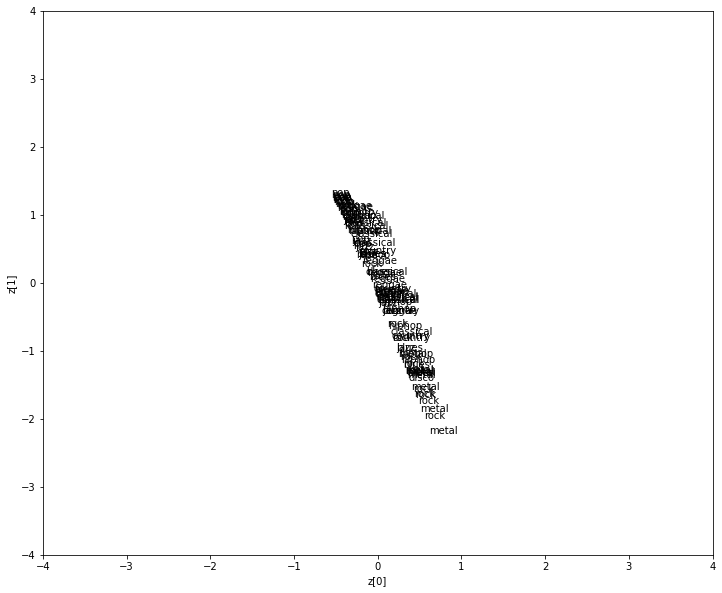

latent_dim = 3
Epoch 1/50
7/7 [==============================] - 3s 253ms/step - loss: 46.6317 - val_loss: 35.7459
Epoch 2/50
7/7 [==============================] - 1s 203ms/step - loss: 35.0647 - val_loss: 33.0020
Epoch 3/50
7/7 [==============================] - 1s 203ms/step - loss: 32.3135 - val_loss: 30.1913
Epoch 4/50
7/7 [==============================] - 1s 200ms/step - loss: 28.9696 - val_loss: 26.6621
Epoch 5/50
7/7 [==============================] - 1s 201ms/step - loss: 24.8028 - val_loss: 22.9080
Epoch 6/50
7/7 [==============================] - 1s 201ms/step - loss: 22.0225 - val_loss: 21.5500
Epoch 7/50
7/7 [==============================] - 1s 198ms/step - loss: 20.4568 - val_loss: 19.8001
Epoch 8/50
7/7 [==============================] - 1s 206ms/step - loss: 19.1389 - val_loss: 19.2632
Epoch 9/50
7/7 [==============================] - 1s 198ms/step - loss: 18.1584 - val_loss: 17.8445
Epoch 10/50
7/7 [==============================] - 1s 204ms/step - loss: 17.1471 - va

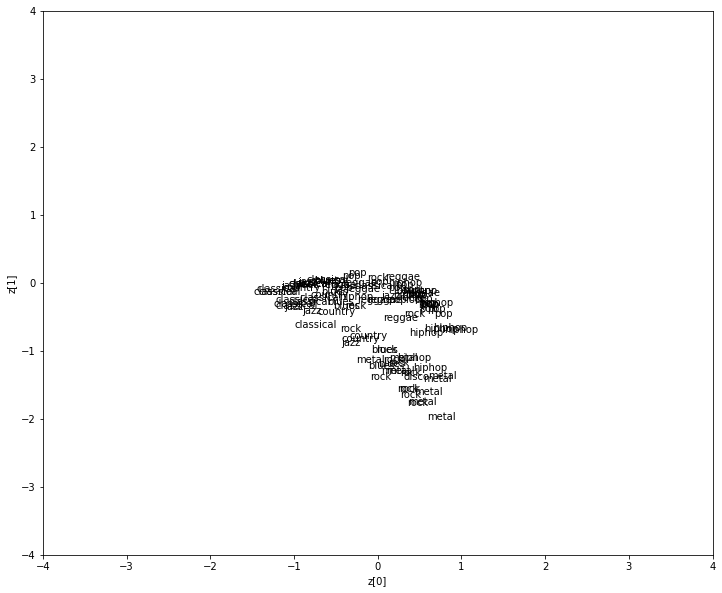

latent_dim = 4
Epoch 1/50
7/7 [==============================] - 3s 250ms/step - loss: 46.9120 - val_loss: 35.9034
Epoch 2/50
7/7 [==============================] - 1s 199ms/step - loss: 34.8981 - val_loss: 32.9326
Epoch 3/50
7/7 [==============================] - 1s 195ms/step - loss: 32.6560 - val_loss: 30.7117
Epoch 4/50
7/7 [==============================] - 1s 198ms/step - loss: 30.0331 - val_loss: 27.9196
Epoch 5/50
7/7 [==============================] - 1s 196ms/step - loss: 26.7257 - val_loss: 24.7405
Epoch 6/50
7/7 [==============================] - 1s 201ms/step - loss: 23.3267 - val_loss: 22.4708
Epoch 7/50
7/7 [==============================] - 1s 197ms/step - loss: 21.1055 - val_loss: 20.2197
Epoch 8/50
7/7 [==============================] - 1s 201ms/step - loss: 19.5937 - val_loss: 19.9300
Epoch 9/50
7/7 [==============================] - 1s 198ms/step - loss: 18.8014 - val_loss: 18.4462
Epoch 10/50
7/7 [==============================] - 1s 197ms/step - loss: 17.6584 - va

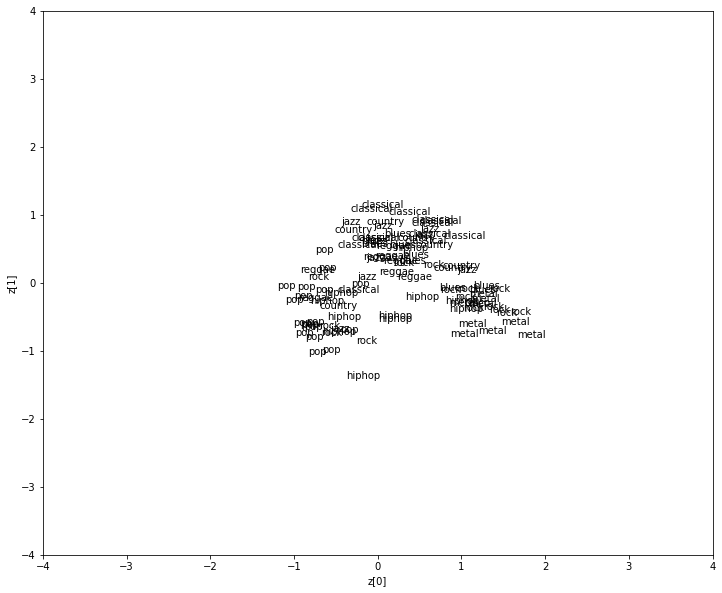

latent_dim = 5
Epoch 1/50
7/7 [==============================] - 3s 245ms/step - loss: 48.2124 - val_loss: 35.8359
Epoch 2/50
7/7 [==============================] - 1s 201ms/step - loss: 34.5135 - val_loss: 31.9488
Epoch 3/50
7/7 [==============================] - 1s 200ms/step - loss: 31.2958 - val_loss: 28.9462
Epoch 4/50
7/7 [==============================] - 1s 204ms/step - loss: 26.7054 - val_loss: 23.9695
Epoch 5/50
7/7 [==============================] - 1s 207ms/step - loss: 22.8917 - val_loss: 21.8058
Epoch 6/50
7/7 [==============================] - 1s 202ms/step - loss: 20.9940 - val_loss: 20.1768
Epoch 7/50
7/7 [==============================] - 1s 200ms/step - loss: 19.5186 - val_loss: 19.2636
Epoch 8/50
7/7 [==============================] - 1s 204ms/step - loss: 18.4103 - val_loss: 18.3142
Epoch 9/50
7/7 [==============================] - 1s 205ms/step - loss: 17.6386 - val_loss: 17.6348
Epoch 10/50
7/7 [==============================] - 1s 205ms/step - loss: 17.0020 - va

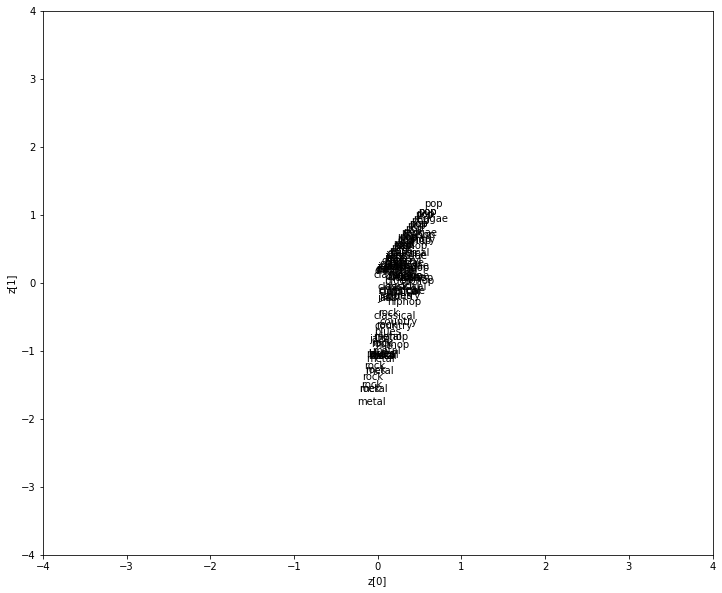

latent_dim = 6
Epoch 1/50
7/7 [==============================] - 4s 244ms/step - loss: 47.2066 - val_loss: 35.0695
Epoch 2/50
7/7 [==============================] - 1s 202ms/step - loss: 34.3281 - val_loss: 32.3083
Epoch 3/50
7/7 [==============================] - 1s 207ms/step - loss: 31.7101 - val_loss: 29.8959
Epoch 4/50
7/7 [==============================] - 1s 199ms/step - loss: 28.4788 - val_loss: 26.5248
Epoch 5/50
7/7 [==============================] - 1s 198ms/step - loss: 24.4390 - val_loss: 22.7086
Epoch 6/50
7/7 [==============================] - 1s 201ms/step - loss: 21.6192 - val_loss: 20.6777
Epoch 7/50
7/7 [==============================] - 1s 202ms/step - loss: 19.7344 - val_loss: 19.3049
Epoch 8/50
7/7 [==============================] - 1s 201ms/step - loss: 18.7115 - val_loss: 20.3590
Epoch 9/50
7/7 [==============================] - 1s 197ms/step - loss: 18.1615 - val_loss: 17.6406
Epoch 10/50
7/7 [==============================] - 1s 199ms/step - loss: 17.1836 - va

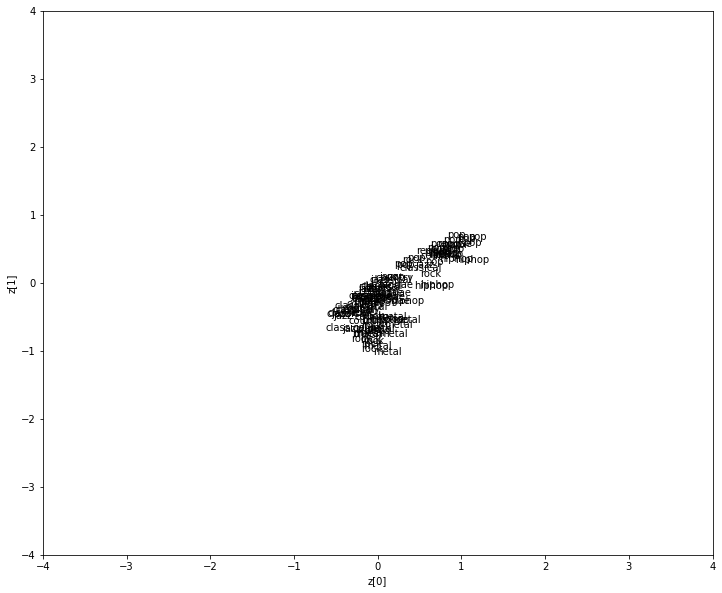

latent_dim = 7
Epoch 1/50
7/7 [==============================] - 3s 253ms/step - loss: 49.3666 - val_loss: 36.3557
Epoch 2/50
7/7 [==============================] - 1s 204ms/step - loss: 35.4786 - val_loss: 33.0924
Epoch 3/50
7/7 [==============================] - 1s 204ms/step - loss: 32.4774 - val_loss: 31.0254
Epoch 4/50
7/7 [==============================] - 1s 203ms/step - loss: 29.8685 - val_loss: 27.5109
Epoch 5/50
7/7 [==============================] - 1s 207ms/step - loss: 26.0931 - val_loss: 23.9090
Epoch 6/50
7/7 [==============================] - 1s 204ms/step - loss: 22.7149 - val_loss: 22.0266
Epoch 7/50
7/7 [==============================] - 1s 203ms/step - loss: 21.3381 - val_loss: 20.6145
Epoch 8/50
7/7 [==============================] - 1s 211ms/step - loss: 19.8323 - val_loss: 19.4514
Epoch 9/50
7/7 [==============================] - 1s 205ms/step - loss: 19.0030 - val_loss: 18.4865
Epoch 10/50
7/7 [==============================] - 1s 211ms/step - loss: 18.2070 - va

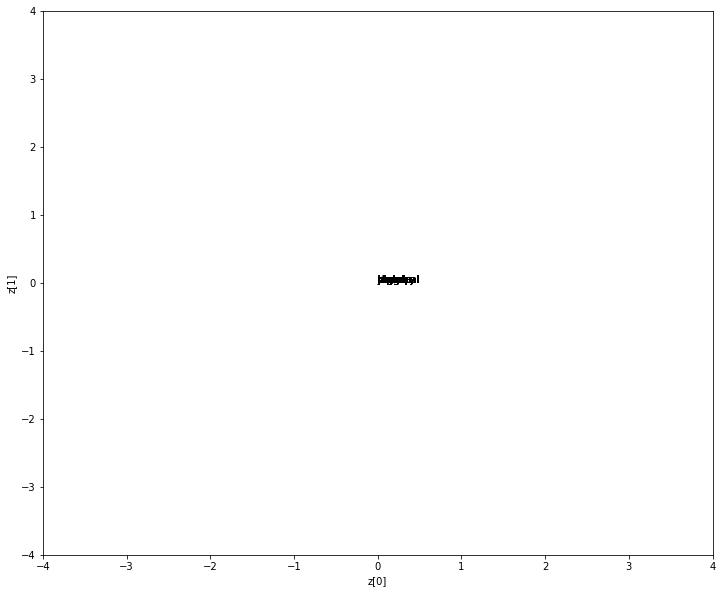

latent_dim = 8
Epoch 1/50
7/7 [==============================] - 4s 257ms/step - loss: 48.2427 - val_loss: 36.6152
Epoch 2/50
7/7 [==============================] - 1s 212ms/step - loss: 35.7437 - val_loss: 33.6049
Epoch 3/50
7/7 [==============================] - 1s 201ms/step - loss: 32.7424 - val_loss: 30.8182
Epoch 4/50
7/7 [==============================] - 2s 225ms/step - loss: 30.2471 - val_loss: 28.4822
Epoch 5/50
7/7 [==============================] - 2s 222ms/step - loss: 27.0036 - val_loss: 25.2056
Epoch 6/50
7/7 [==============================] - 2s 219ms/step - loss: 23.9162 - val_loss: 23.8684
Epoch 7/50
7/7 [==============================] - 1s 213ms/step - loss: 21.8179 - val_loss: 20.9947
Epoch 8/50
7/7 [==============================] - 1s 205ms/step - loss: 20.4814 - val_loss: 19.9402
Epoch 9/50
7/7 [==============================] - 1s 206ms/step - loss: 18.9181 - val_loss: 18.8270
Epoch 10/50
7/7 [==============================] - 1s 202ms/step - loss: 18.3135 - va

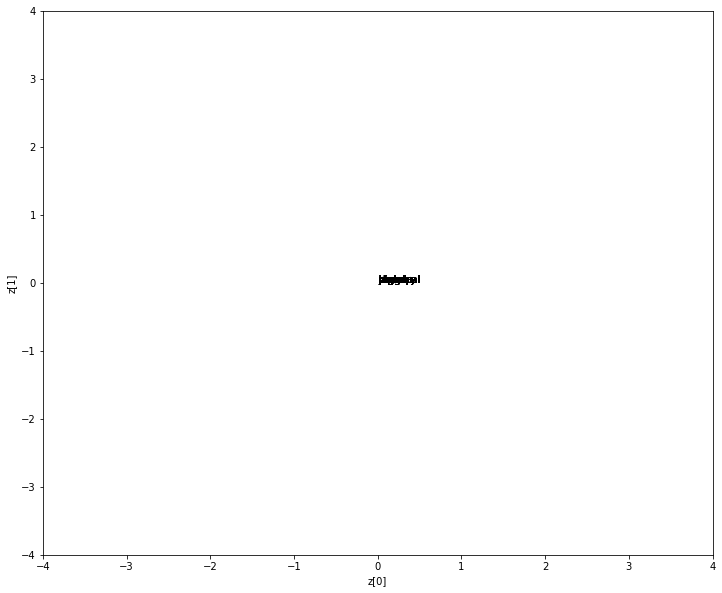

latent_dim = 9
Epoch 1/50
7/7 [==============================] - 4s 264ms/step - loss: 47.4080 - val_loss: 34.8401
Epoch 2/50
7/7 [==============================] - 1s 202ms/step - loss: 33.8044 - val_loss: 31.6305
Epoch 3/50
7/7 [==============================] - 1s 208ms/step - loss: 30.5556 - val_loss: 28.7659
Epoch 4/50
7/7 [==============================] - 1s 204ms/step - loss: 26.5359 - val_loss: 24.4016
Epoch 5/50
7/7 [==============================] - 1s 203ms/step - loss: 23.1932 - val_loss: 22.2650
Epoch 6/50
7/7 [==============================] - 1s 201ms/step - loss: 21.2645 - val_loss: 21.4175
Epoch 7/50
7/7 [==============================] - 1s 202ms/step - loss: 19.8787 - val_loss: 19.9010
Epoch 8/50
7/7 [==============================] - 1s 207ms/step - loss: 19.0080 - val_loss: 18.5765
Epoch 9/50
7/7 [==============================] - 1s 200ms/step - loss: 18.0675 - val_loss: 18.1900
Epoch 10/50
7/7 [==============================] - 1s 199ms/step - loss: 17.4916 - va

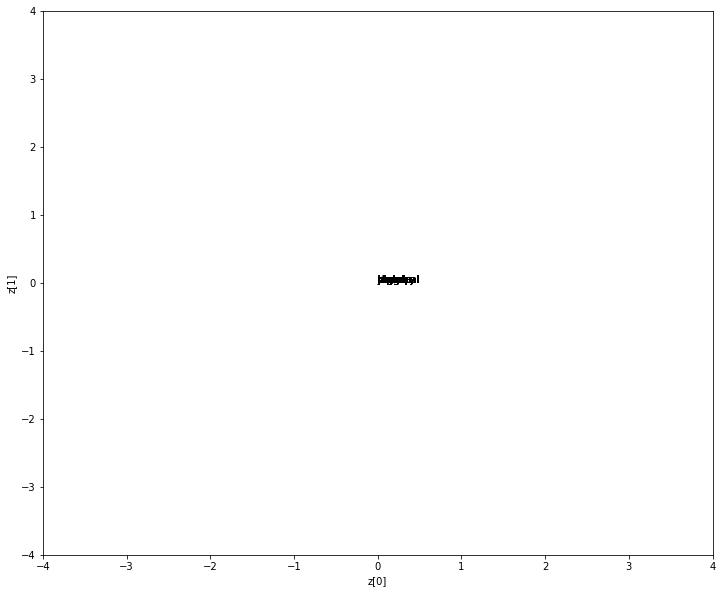

latent_dim = 10
Epoch 1/50
7/7 [==============================] - 3s 256ms/step - loss: 44.8045 - val_loss: 34.1346
Epoch 2/50
7/7 [==============================] - 1s 202ms/step - loss: 33.3887 - val_loss: 31.2455
Epoch 3/50
7/7 [==============================] - 1s 201ms/step - loss: 30.3102 - val_loss: 27.8837
Epoch 4/50
7/7 [==============================] - 1s 202ms/step - loss: 26.3346 - val_loss: 23.8188
Epoch 5/50
7/7 [==============================] - 1s 203ms/step - loss: 22.5215 - val_loss: 21.8880
Epoch 6/50
7/7 [==============================] - 1s 208ms/step - loss: 20.7690 - val_loss: 20.2741
Epoch 7/50
7/7 [==============================] - 1s 199ms/step - loss: 19.5384 - val_loss: 19.4938
Epoch 8/50
7/7 [==============================] - 1s 201ms/step - loss: 18.6895 - val_loss: 18.7102
Epoch 9/50
7/7 [==============================] - 1s 196ms/step - loss: 17.9142 - val_loss: 17.9364
Epoch 10/50
7/7 [==============================] - 1s 198ms/step - loss: 17.4214 - v

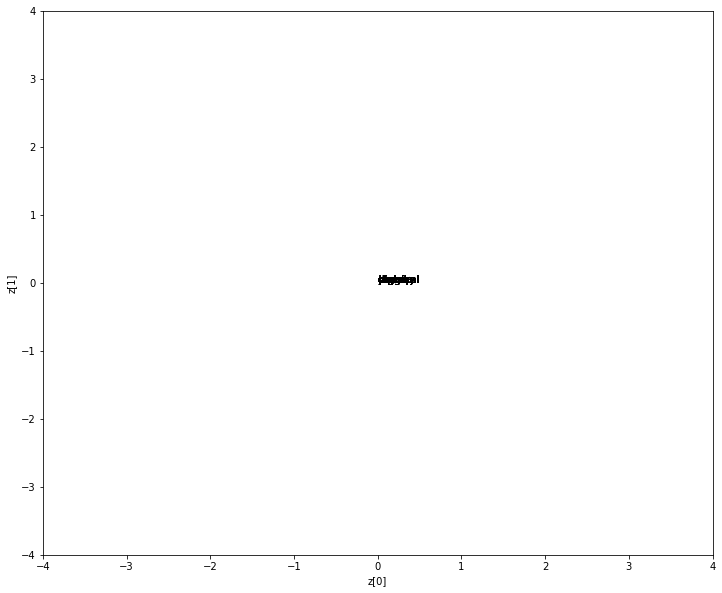

latent_dim = 11
Epoch 1/50
7/7 [==============================] - 4s 271ms/step - loss: 44.7440 - val_loss: 33.6648
Epoch 2/50
7/7 [==============================] - 2s 216ms/step - loss: 32.6579 - val_loss: 30.6031
Epoch 3/50
7/7 [==============================] - 2s 245ms/step - loss: 29.1078 - val_loss: 26.9328
Epoch 4/50
7/7 [==============================] - 2s 263ms/step - loss: 25.0114 - val_loss: 23.4682
Epoch 5/50
7/7 [==============================] - 2s 268ms/step - loss: 21.9301 - val_loss: 21.2392
Epoch 6/50
7/7 [==============================] - 1s 215ms/step - loss: 20.5520 - val_loss: 19.7914
Epoch 7/50
7/7 [==============================] - 1s 205ms/step - loss: 19.3047 - val_loss: 19.0351
Epoch 8/50
7/7 [==============================] - 1s 215ms/step - loss: 18.1707 - val_loss: 18.7879
Epoch 9/50
7/7 [==============================] - 2s 215ms/step - loss: 17.6806 - val_loss: 17.2364
Epoch 10/50
7/7 [==============================] - 2s 222ms/step - loss: 16.7955 - v

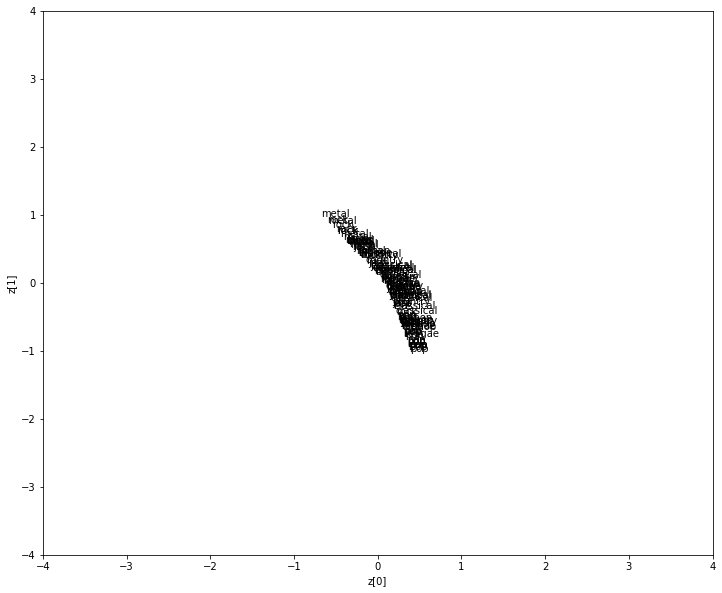

latent_dim = 12
Epoch 1/50
7/7 [==============================] - 4s 250ms/step - loss: 46.2587 - val_loss: 34.1674
Epoch 2/50
7/7 [==============================] - 1s 198ms/step - loss: 33.2423 - val_loss: 31.4787
Epoch 3/50
7/7 [==============================] - 1s 198ms/step - loss: 30.5220 - val_loss: 28.4844
Epoch 4/50
7/7 [==============================] - 1s 196ms/step - loss: 27.2254 - val_loss: 26.4988
Epoch 5/50
7/7 [==============================] - 1s 199ms/step - loss: 23.8431 - val_loss: 22.9317
Epoch 6/50
7/7 [==============================] - 1s 196ms/step - loss: 21.6413 - val_loss: 20.7143
Epoch 7/50
7/7 [==============================] - 1s 197ms/step - loss: 19.8306 - val_loss: 19.7005
Epoch 8/50
7/7 [==============================] - 1s 201ms/step - loss: 19.2312 - val_loss: 18.7216
Epoch 9/50
7/7 [==============================] - 1s 202ms/step - loss: 18.4310 - val_loss: 17.9120
Epoch 10/50
7/7 [==============================] - 1s 206ms/step - loss: 17.2058 - v

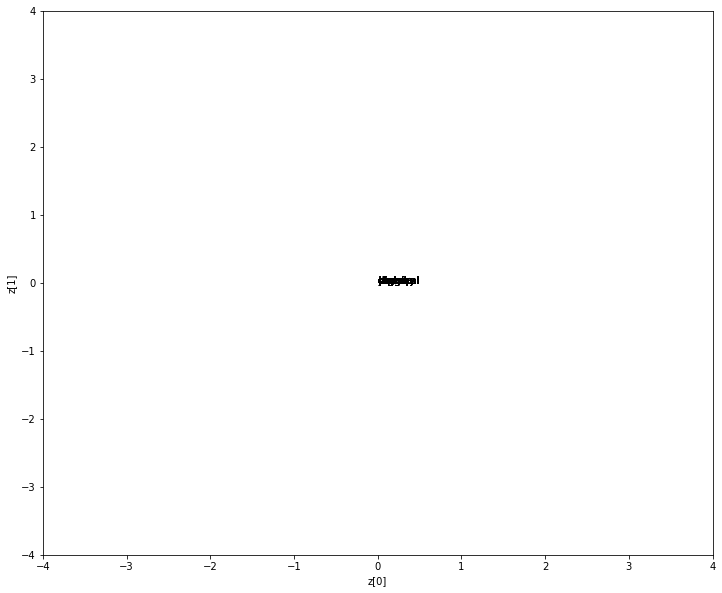

latent_dim = 13
Epoch 1/50
7/7 [==============================] - 4s 250ms/step - loss: 46.4004 - val_loss: 35.1840
Epoch 2/50
7/7 [==============================] - 1s 215ms/step - loss: 34.5269 - val_loss: 33.1886
Epoch 3/50
7/7 [==============================] - 2s 215ms/step - loss: 32.5224 - val_loss: 31.0102
Epoch 4/50
7/7 [==============================] - 1s 211ms/step - loss: 30.2843 - val_loss: 28.4456
Epoch 5/50
7/7 [==============================] - 2s 215ms/step - loss: 26.8352 - val_loss: 24.8857
Epoch 6/50
7/7 [==============================] - 1s 210ms/step - loss: 23.2122 - val_loss: 22.2911
Epoch 7/50
7/7 [==============================] - 2s 217ms/step - loss: 21.1675 - val_loss: 21.0450
Epoch 8/50
7/7 [==============================] - 1s 211ms/step - loss: 19.5672 - val_loss: 19.1869
Epoch 9/50
7/7 [==============================] - 1s 213ms/step - loss: 18.8499 - val_loss: 18.7768
Epoch 10/50
7/7 [==============================] - 1s 207ms/step - loss: 17.4779 - v

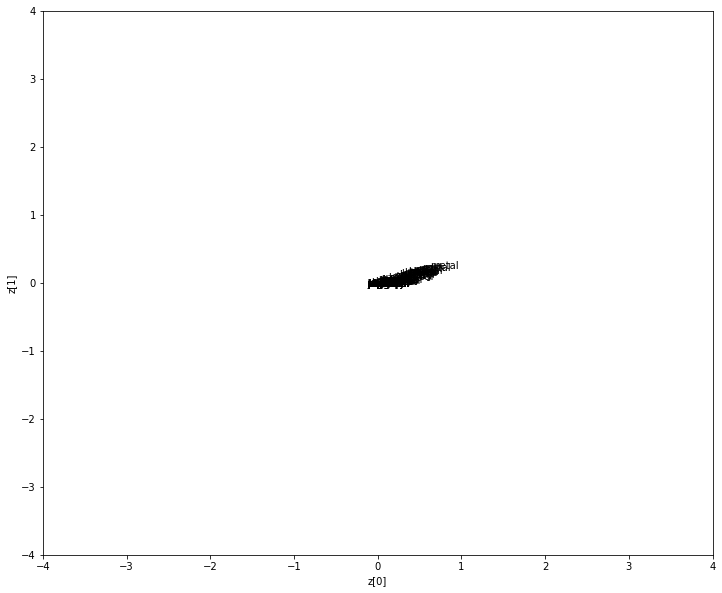

latent_dim = 14
Epoch 1/50
7/7 [==============================] - 3s 254ms/step - loss: 47.1859 - val_loss: 35.8470
Epoch 2/50
7/7 [==============================] - 1s 203ms/step - loss: 34.8273 - val_loss: 32.8429
Epoch 3/50
7/7 [==============================] - 1s 197ms/step - loss: 31.9641 - val_loss: 30.3262
Epoch 4/50
7/7 [==============================] - 1s 195ms/step - loss: 29.6889 - val_loss: 27.6032
Epoch 5/50
7/7 [==============================] - 1s 201ms/step - loss: 26.0359 - val_loss: 24.9367
Epoch 6/50
7/7 [==============================] - 1s 195ms/step - loss: 23.2195 - val_loss: 22.1867
Epoch 7/50
7/7 [==============================] - 1s 194ms/step - loss: 21.2733 - val_loss: 20.8794
Epoch 8/50
7/7 [==============================] - 1s 196ms/step - loss: 19.8116 - val_loss: 19.7939
Epoch 9/50
7/7 [==============================] - 1s 192ms/step - loss: 19.3161 - val_loss: 18.6951
Epoch 10/50
7/7 [==============================] - 1s 195ms/step - loss: 18.1107 - v

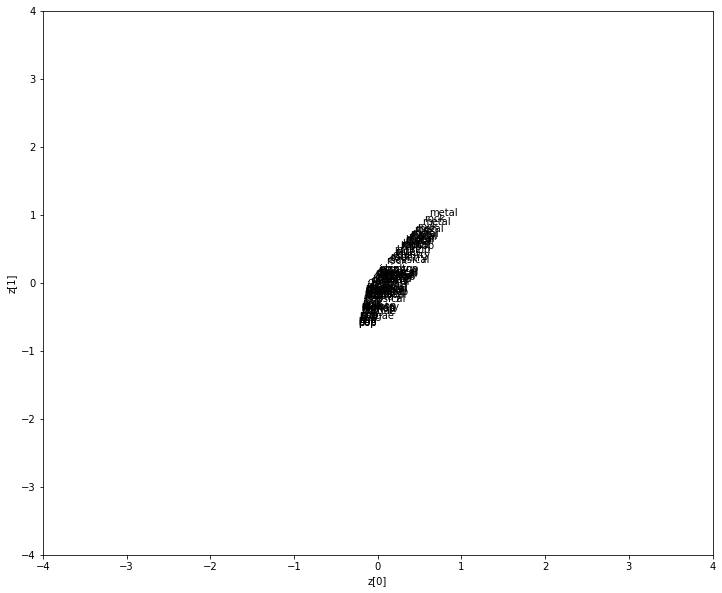

latent_dim = 15
Epoch 1/50
7/7 [==============================] - 3s 248ms/step - loss: 46.3676 - val_loss: 35.2132
Epoch 2/50
7/7 [==============================] - 1s 198ms/step - loss: 34.0641 - val_loss: 31.8805
Epoch 3/50
7/7 [==============================] - 1s 204ms/step - loss: 31.4058 - val_loss: 29.7616
Epoch 4/50
7/7 [==============================] - 1s 201ms/step - loss: 28.4264 - val_loss: 26.3614
Epoch 5/50
7/7 [==============================] - 1s 202ms/step - loss: 24.7826 - val_loss: 23.3320
Epoch 6/50
7/7 [==============================] - 1s 200ms/step - loss: 22.3594 - val_loss: 21.5843
Epoch 7/50
7/7 [==============================] - 1s 200ms/step - loss: 20.4590 - val_loss: 20.8510
Epoch 8/50
7/7 [==============================] - 1s 200ms/step - loss: 19.6147 - val_loss: 18.8094
Epoch 9/50
7/7 [==============================] - 1s 205ms/step - loss: 18.6292 - val_loss: 18.3915
Epoch 10/50
7/7 [==============================] - 1s 204ms/step - loss: 17.6237 - v

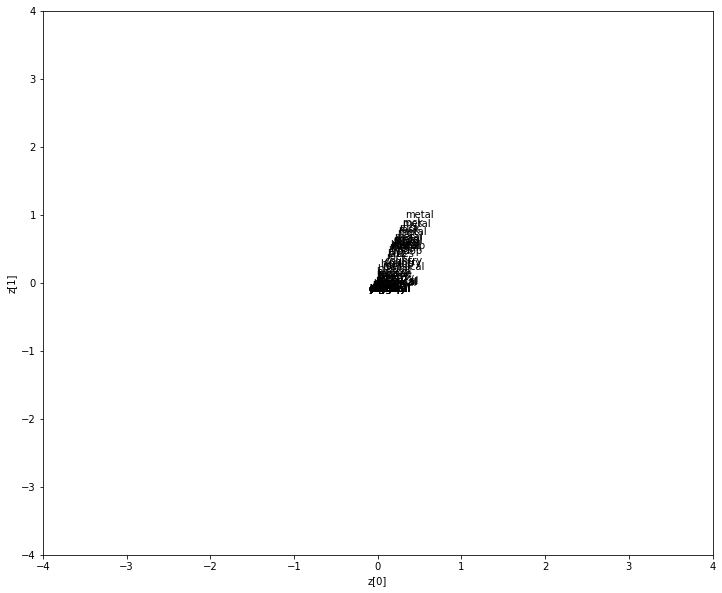

latent_dim = 16
Epoch 1/50
7/7 [==============================] - 4s 266ms/step - loss: 47.0241 - val_loss: 34.2873
Epoch 2/50
7/7 [==============================] - 1s 205ms/step - loss: 33.4488 - val_loss: 31.9491
Epoch 3/50
7/7 [==============================] - 1s 215ms/step - loss: 31.2906 - val_loss: 29.4841
Epoch 4/50
7/7 [==============================] - 1s 204ms/step - loss: 28.1864 - val_loss: 26.0428
Epoch 5/50
7/7 [==============================] - 1s 203ms/step - loss: 23.8676 - val_loss: 22.4084
Epoch 6/50
7/7 [==============================] - 1s 208ms/step - loss: 21.3462 - val_loss: 20.7168
Epoch 7/50
7/7 [==============================] - 1s 205ms/step - loss: 19.8054 - val_loss: 19.5457
Epoch 8/50
7/7 [==============================] - 1s 215ms/step - loss: 18.8357 - val_loss: 18.7514
Epoch 9/50
7/7 [==============================] - 1s 202ms/step - loss: 17.9065 - val_loss: 17.9279
Epoch 10/50
7/7 [==============================] - 1s 208ms/step - loss: 17.3453 - v

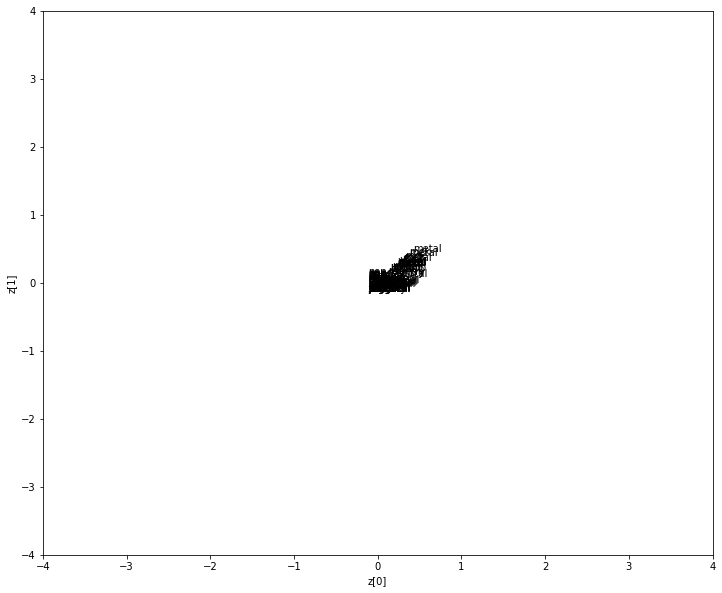

latent_dim = 17
Epoch 1/50
7/7 [==============================] - 3s 252ms/step - loss: 47.2332 - val_loss: 34.1227
Epoch 2/50
7/7 [==============================] - 2s 213ms/step - loss: 32.9563 - val_loss: 30.7066
Epoch 3/50
7/7 [==============================] - 2s 216ms/step - loss: 29.5913 - val_loss: 26.9970
Epoch 4/50
7/7 [==============================] - 2s 281ms/step - loss: 25.5145 - val_loss: 23.9123
Epoch 5/50
7/7 [==============================] - 2s 249ms/step - loss: 23.1381 - val_loss: 22.9088
Epoch 6/50
7/7 [==============================] - 2s 260ms/step - loss: 21.6087 - val_loss: 21.0313
Epoch 7/50
7/7 [==============================] - 2s 247ms/step - loss: 19.9692 - val_loss: 19.7378
Epoch 8/50
7/7 [==============================] - 2s 294ms/step - loss: 19.4792 - val_loss: 18.9706
Epoch 9/50
7/7 [==============================] - 2s 330ms/step - loss: 18.4669 - val_loss: 18.3130
Epoch 10/50
7/7 [==============================] - 1s 214ms/step - loss: 17.5993 - v

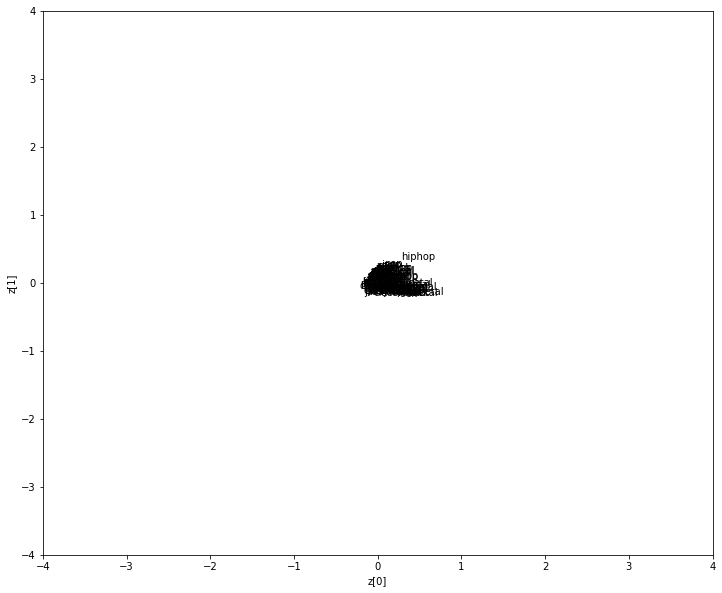

latent_dim = 18
Epoch 1/50
7/7 [==============================] - 4s 268ms/step - loss: 44.2696 - val_loss: 34.1813
Epoch 2/50
7/7 [==============================] - 2s 219ms/step - loss: 33.1340 - val_loss: 31.3413
Epoch 3/50
7/7 [==============================] - 2s 216ms/step - loss: 30.3416 - val_loss: 28.6990
Epoch 4/50
7/7 [==============================] - 2s 221ms/step - loss: 26.9904 - val_loss: 24.8832
Epoch 5/50
7/7 [==============================] - 2s 212ms/step - loss: 23.4359 - val_loss: 23.8465
Epoch 6/50
7/7 [==============================] - 2s 211ms/step - loss: 21.6796 - val_loss: 21.0065
Epoch 7/50
7/7 [==============================] - 1s 210ms/step - loss: 20.1983 - val_loss: 19.8858
Epoch 8/50
7/7 [==============================] - 1s 208ms/step - loss: 18.9215 - val_loss: 19.0049
Epoch 9/50
7/7 [==============================] - 2s 221ms/step - loss: 18.2264 - val_loss: 18.0777
Epoch 10/50
7/7 [==============================] - 1s 213ms/step - loss: 17.6156 - v

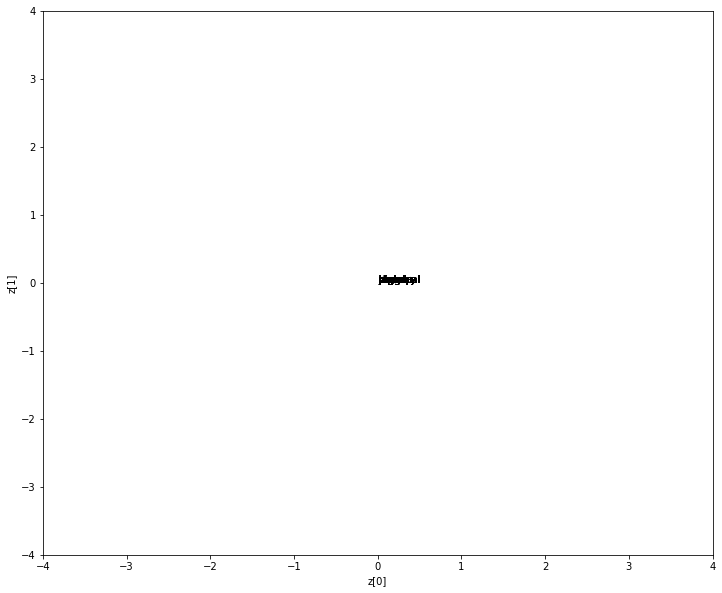

latent_dim = 19
Epoch 1/50
7/7 [==============================] - 4s 295ms/step - loss: 44.3558 - val_loss: 33.3880
Epoch 2/50
7/7 [==============================] - 2s 238ms/step - loss: 32.6050 - val_loss: 30.8739
Epoch 3/50
7/7 [==============================] - 2s 219ms/step - loss: 29.9877 - val_loss: 27.3179
Epoch 4/50
7/7 [==============================] - 2s 221ms/step - loss: 25.2812 - val_loss: 24.0787
Epoch 5/50
7/7 [==============================] - 2s 215ms/step - loss: 22.2843 - val_loss: 21.3438
Epoch 6/50
7/7 [==============================] - 2s 227ms/step - loss: 20.2885 - val_loss: 20.5865
Epoch 7/50
7/7 [==============================] - 2s 218ms/step - loss: 19.4040 - val_loss: 18.6831
Epoch 8/50
7/7 [==============================] - 2s 232ms/step - loss: 18.0472 - val_loss: 18.2808
Epoch 9/50
7/7 [==============================] - 2s 227ms/step - loss: 17.5024 - val_loss: 17.6194
Epoch 10/50
7/7 [==============================] - 2s 233ms/step - loss: 16.4294 - v

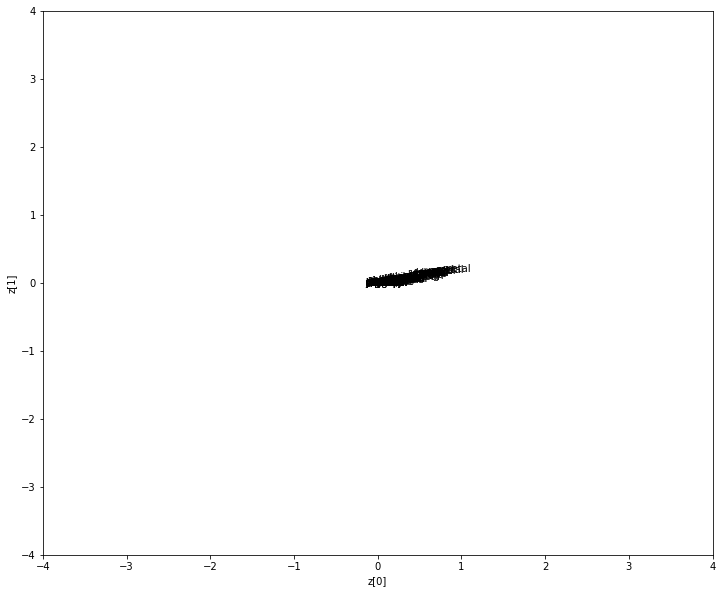

latent_dim = 20
Epoch 1/50
7/7 [==============================] - 4s 282ms/step - loss: 48.1563 - val_loss: 34.5482
Epoch 2/50
7/7 [==============================] - 2s 220ms/step - loss: 33.8269 - val_loss: 31.8837
Epoch 3/50
7/7 [==============================] - 2s 226ms/step - loss: 31.4501 - val_loss: 29.7996
Epoch 4/50
7/7 [==============================] - 2s 216ms/step - loss: 28.1651 - val_loss: 26.3541
Epoch 5/50
7/7 [==============================] - 2s 220ms/step - loss: 24.6640 - val_loss: 22.8334
Epoch 6/50
7/7 [==============================] - 2s 224ms/step - loss: 22.0230 - val_loss: 21.9184
Epoch 7/50
7/7 [==============================] - 2s 223ms/step - loss: 20.5119 - val_loss: 20.1074
Epoch 8/50
7/7 [==============================] - 2s 218ms/step - loss: 19.6093 - val_loss: 19.2898
Epoch 9/50
7/7 [==============================] - 2s 218ms/step - loss: 18.7559 - val_loss: 18.3675
Epoch 10/50
7/7 [==============================] - 2s 217ms/step - loss: 17.8243 - v

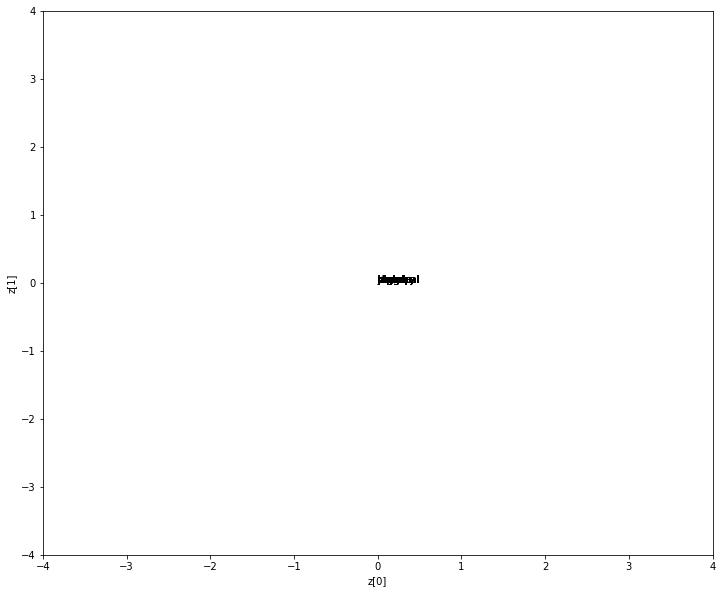

In [ ]:
hist_1d = []
for i in range(2, 21):
  print('latent_dim =', i)
  history = VAE_2DCNN(latent_dim=i)
  hist_1d.append(history)
  print("="*50)

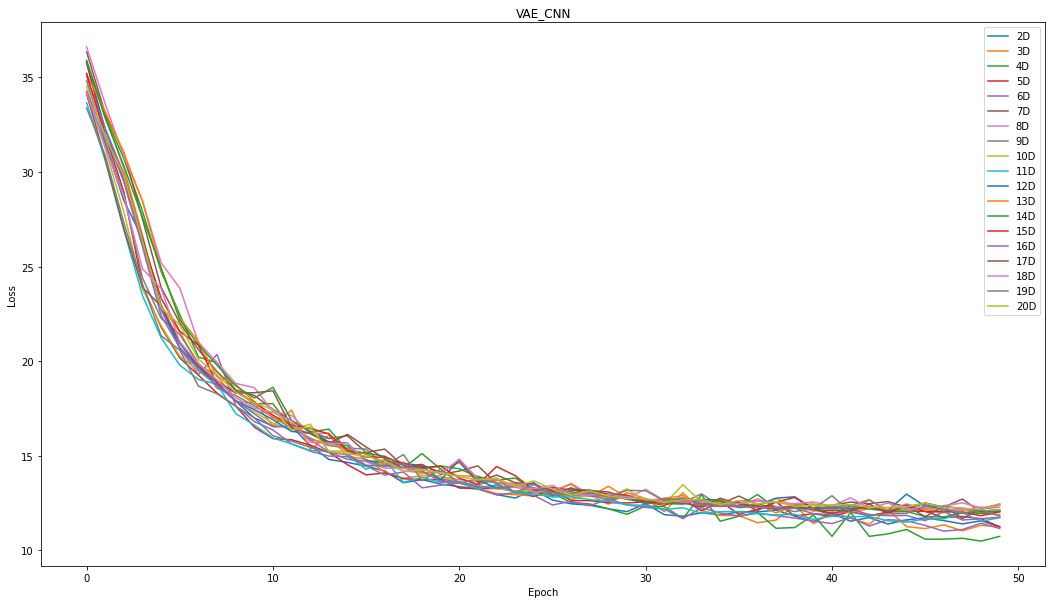

In [ ]:
plt.figure(figsize=(18,10))
# loss 시각화
for i in range(len(hist_1d)):
  plt.plot(hist_1d[i].history['val_loss'])
plt.title('VAE_CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([str(i)+'D' for i in range(2, 21)], loc='upper right')
plt.show()

## VAE_MLP

In [ ]:
ORIGINAL_DIM = 640
PATH = '/content/drive/MyDrive/기계팀플/vae_final/'

In [ ]:
# 병합시킨 데이터
X = pd.read_csv(PATH+'concat_features.csv', encoding='utf-8')
Y = X['label']
X = X.drop(columns='label')

# padding
X['filename'] = 0
temp = pd.DataFrame(X['filename'])
for i in range(11):
  X['padding'+str(i)] = temp

# 정규화
X = X.values.reshape(-1, ORIGINAL_DIM).astype('float32')
X = X / 255
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)

In [ ]:
# VAE_MLP
def vae_mlp(LATENT_DIM):
  input_shape = (ORIGINAL_DIM, )
  intermediate_dim = 512
  batch_size = 128
  latent_dim = LATENT_DIM
  epochs = 50

  inputs = Input(shape=input_shape, name='encoder_input')
  x = Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)

  z = Lambda(sampling,
            output_shape=(latent_dim,),
            name='z')([z_mean, z_log_var])

  # instantiate encoder
  encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
  # encoder.summary()
  # plot_model(encoder,
  #           to_file=PATH+'vae_mlp_encoder'+str(latent_dim)+'.png',
  #           show_shapes=True)

  # decoder model building
  latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
  x = Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = Dense(ORIGINAL_DIM, activation='sigmoid')(x)

  # instantiate decoder model
  decoder = Model(latent_inputs, outputs, name='decoder')
  # decoder.summary()
  # plot_model(decoder,
  #           to_file=PATH+'vae_mlp_decoder'+str(latent_dim)+'.png', 
  #           show_shapes=True)

  outputs = decoder(encoder(inputs)[2])
  vae = Model(inputs, outputs, name='vae_mlp_model'+str(latent_dim))


  if __name__ == '__main__':
    parser = argparse.ArgumentParser()  # 파서 만들기
    help_ = "Load tf model trained weights"
    parser.add_argument("-w", "--weights", help=help_)  # 인자 추가
    help_ = "Use binary cross entropy instead of mse (default)"
    parser.add_argument("--bce", help=help_, action='store_true')   # bce가 쓰이면 True로 저장됨
    args = parser.parse_args('')

    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.bce:
        reconstruction_loss = binary_crossentropy(inputs,outputs)
    else:
        reconstruction_loss = mse(inputs, outputs)

    reconstruction_loss *= ORIGINAL_DIM
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    
    save_dir ="vae_mlp_weights"+str(latent_dim)
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    if args.weights:
        filepath = os.path.join(save_dir, args.weights)
        vae = vae.load_weights(filepath)
    else:
        # train the autoencoder
        history = vae.fit(x_train,
                          epochs=epochs,
                          batch_size=batch_size,
                          validation_data=(x_test, None))
        filepath = os.path.join(save_dir, 'vae_mlp.tf')
        vae.save_weights(filepath)
        vae.save('/content/drive/MyDrive/기계팀플/vae_final/vae_mlp.h5')
        encoder.save('/content/drive/MyDrive/기계팀플/vae_final/vae_encoder.h5')
        encoder.save_weights('/content/drive/MyDrive/기계팀플/vae_final/encoder_weights.h5')

    plot_results(models,
                  data,
                  batch_size=batch_size,
                  model_name=PATH+"vae_mlp"+str(latent_dim))
    
    return history

latent_dim = 2
Epoch 1/50
7/7 [==============================] - 2s 87ms/step - loss: 52.9382 - val_loss: 42.8204
Epoch 2/50
7/7 [==============================] - 0s 48ms/step - loss: 34.5221 - val_loss: 26.2132
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 22.9117 - val_loss: 18.9598
Epoch 4/50
7/7 [==============================] - 0s 43ms/step - loss: 17.8979 - val_loss: 16.2028
Epoch 5/50
7/7 [==============================] - 0s 38ms/step - loss: 15.7093 - val_loss: 15.0289
Epoch 6/50
7/7 [==============================] - 0s 49ms/step - loss: 14.7470 - val_loss: 14.2336
Epoch 7/50
7/7 [==============================] - 0s 45ms/step - loss: 14.2359 - val_loss: 13.5775
Epoch 8/50
7/7 [==============================] - 0s 36ms/step - loss: 13.5388 - val_loss: 13.0442
Epoch 9/50
7/7 [==============================] - 0s 38ms/step - loss: 12.8072 - val_loss: 12.3874
Epoch 10/50
7/7 [==============================] - 0s 38ms/step - loss: 12.3877 - val_loss: 12

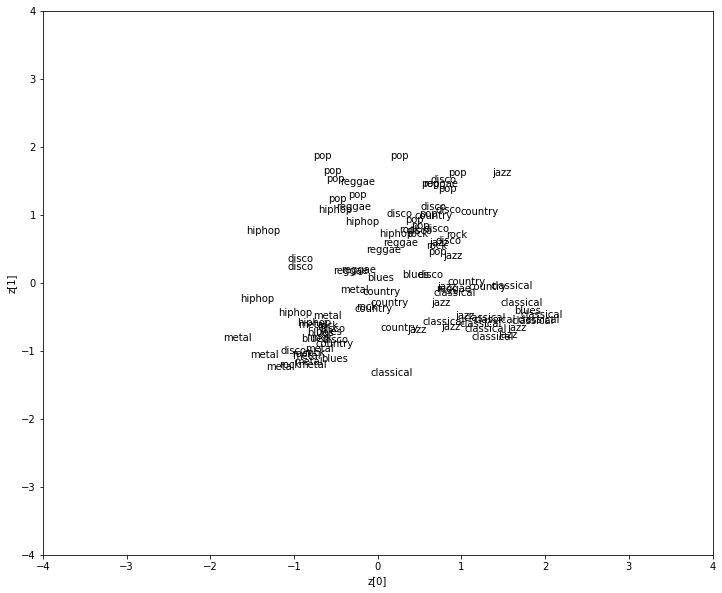

latent_dim = 3
Epoch 1/50
7/7 [==============================] - 2s 80ms/step - loss: 52.8163 - val_loss: 43.5821
Epoch 2/50
7/7 [==============================] - 0s 46ms/step - loss: 37.0448 - val_loss: 27.2553
Epoch 3/50
7/7 [==============================] - 0s 37ms/step - loss: 23.6195 - val_loss: 19.3603
Epoch 4/50
7/7 [==============================] - 0s 40ms/step - loss: 17.6936 - val_loss: 16.0567
Epoch 5/50
7/7 [==============================] - 0s 40ms/step - loss: 15.4778 - val_loss: 14.9946
Epoch 6/50
7/7 [==============================] - 0s 37ms/step - loss: 14.5561 - val_loss: 13.9534
Epoch 7/50
7/7 [==============================] - 0s 41ms/step - loss: 13.9810 - val_loss: 13.1559
Epoch 8/50
7/7 [==============================] - 0s 34ms/step - loss: 13.1707 - val_loss: 12.6398
Epoch 9/50
7/7 [==============================] - 0s 37ms/step - loss: 12.6011 - val_loss: 12.6012
Epoch 10/50
7/7 [==============================] - 0s 40ms/step - loss: 12.5741 - val_loss: 11

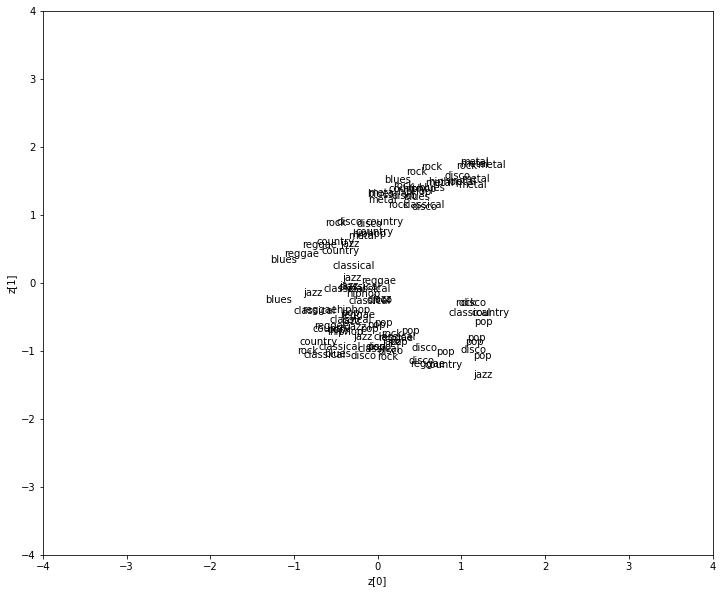

latent_dim = 4
Epoch 1/50
7/7 [==============================] - 1s 53ms/step - loss: 52.1502 - val_loss: 41.9047
Epoch 2/50
7/7 [==============================] - 0s 24ms/step - loss: 34.4545 - val_loss: 25.5666
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 21.9365 - val_loss: 18.2610
Epoch 4/50
7/7 [==============================] - 0s 25ms/step - loss: 17.3629 - val_loss: 15.7754
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 15.5199 - val_loss: 14.4238
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - loss: 14.3488 - val_loss: 14.2404
Epoch 7/50
7/7 [==============================] - 0s 26ms/step - loss: 14.0421 - val_loss: 13.3413
Epoch 8/50
7/7 [==============================] - 0s 25ms/step - loss: 13.4124 - val_loss: 12.9572
Epoch 9/50
7/7 [==============================] - 0s 26ms/step - loss: 12.7868 - val_loss: 12.3330
Epoch 10/50
7/7 [==============================] - 0s 27ms/step - loss: 12.4004 - val_loss: 11

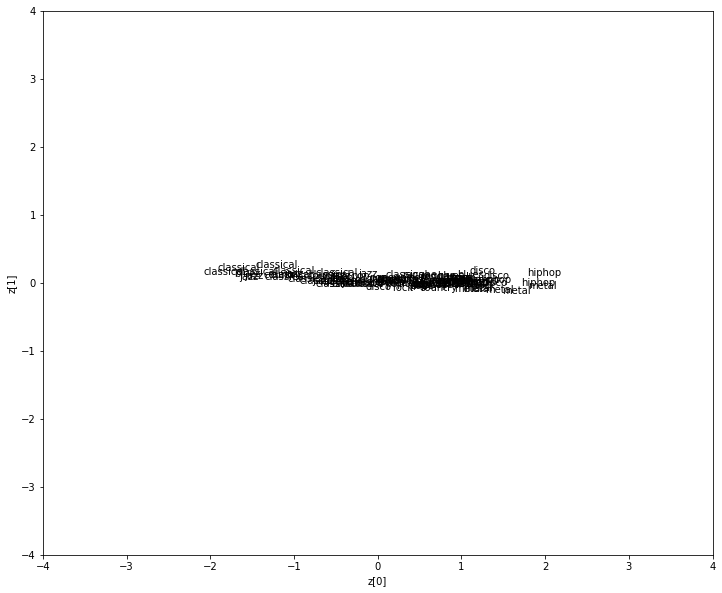

latent_dim = 5
Epoch 1/50
7/7 [==============================] - 1s 52ms/step - loss: 52.5877 - val_loss: 42.4008
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 34.7670 - val_loss: 26.5323
Epoch 3/50
7/7 [==============================] - 0s 26ms/step - loss: 22.0789 - val_loss: 19.2356
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 16.9696 - val_loss: 16.0066
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 15.0377 - val_loss: 14.3897
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 14.1555 - val_loss: 13.6196
Epoch 7/50
7/7 [==============================] - 0s 26ms/step - loss: 13.6393 - val_loss: 12.9393
Epoch 8/50
7/7 [==============================] - 0s 27ms/step - loss: 12.9652 - val_loss: 12.6947
Epoch 9/50
7/7 [==============================] - 0s 28ms/step - loss: 12.5348 - val_loss: 12.3993
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 12.0234 - val_loss: 11

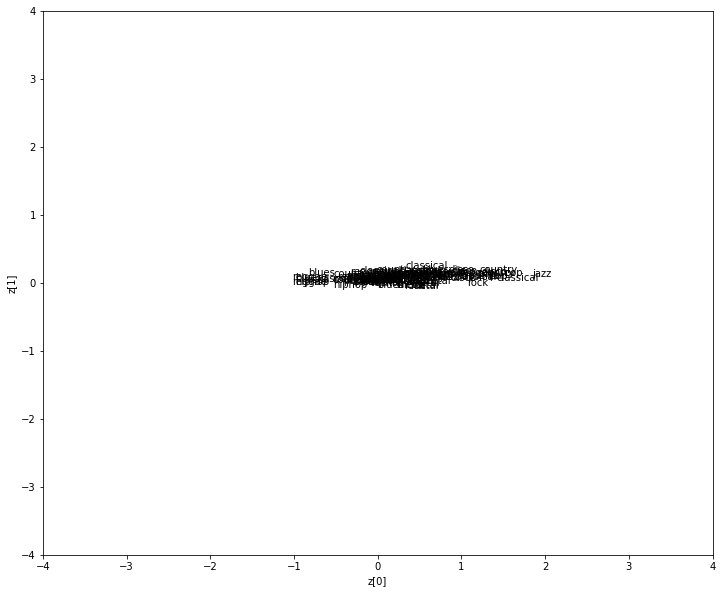

latent_dim = 6
Epoch 1/50
7/7 [==============================] - 2s 89ms/step - loss: 51.7737 - val_loss: 40.2561
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 33.6758 - val_loss: 25.2911
Epoch 3/50
7/7 [==============================] - 0s 38ms/step - loss: 21.6683 - val_loss: 18.3472
Epoch 4/50
7/7 [==============================] - 0s 41ms/step - loss: 16.4189 - val_loss: 15.6822
Epoch 5/50
7/7 [==============================] - 0s 43ms/step - loss: 14.7335 - val_loss: 14.0565
Epoch 6/50
7/7 [==============================] - 0s 41ms/step - loss: 13.9924 - val_loss: 13.7945
Epoch 7/50
7/7 [==============================] - 0s 36ms/step - loss: 13.3689 - val_loss: 12.9180
Epoch 8/50
7/7 [==============================] - 0s 43ms/step - loss: 12.7323 - val_loss: 12.3872
Epoch 9/50
7/7 [==============================] - 0s 42ms/step - loss: 12.3938 - val_loss: 11.8354
Epoch 10/50
7/7 [==============================] - 0s 38ms/step - loss: 11.7691 - val_loss: 12

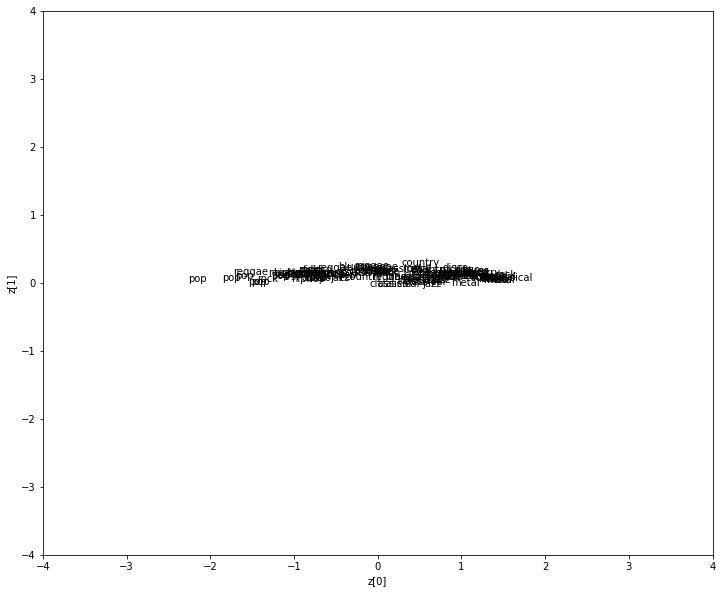

latent_dim = 7
Epoch 1/50
7/7 [==============================] - 3s 139ms/step - loss: 51.0379 - val_loss: 40.2854
Epoch 2/50
7/7 [==============================] - 0s 45ms/step - loss: 32.6989 - val_loss: 23.9670
Epoch 3/50
7/7 [==============================] - 0s 69ms/step - loss: 20.9721 - val_loss: 17.2259
Epoch 4/50
7/7 [==============================] - 0s 46ms/step - loss: 16.2085 - val_loss: 14.7242
Epoch 5/50
7/7 [==============================] - 0s 38ms/step - loss: 14.7205 - val_loss: 14.0641
Epoch 6/50
7/7 [==============================] - 0s 39ms/step - loss: 13.9845 - val_loss: 13.3245
Epoch 7/50
7/7 [==============================] - 0s 47ms/step - loss: 13.1807 - val_loss: 12.6647
Epoch 8/50
7/7 [==============================] - 0s 41ms/step - loss: 12.4278 - val_loss: 11.9303
Epoch 9/50
7/7 [==============================] - 0s 50ms/step - loss: 12.2837 - val_loss: 12.0600
Epoch 10/50
7/7 [==============================] - 0s 45ms/step - loss: 11.8946 - val_loss: 1

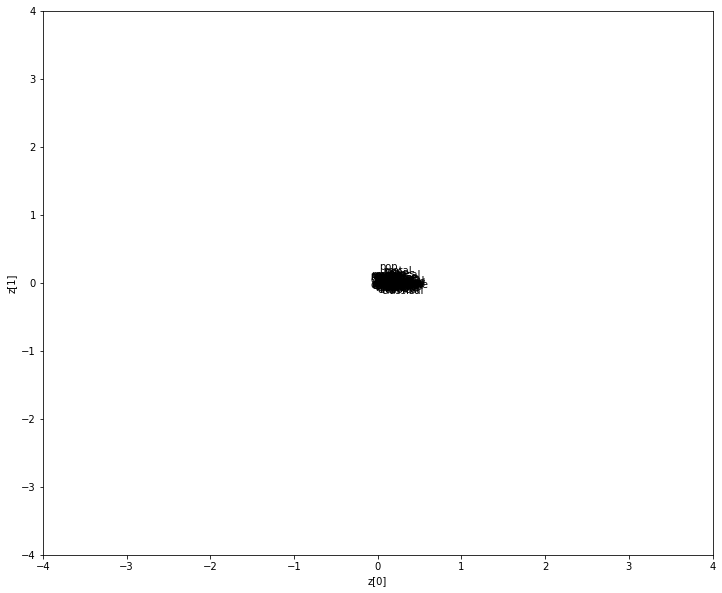

latent_dim = 8
Epoch 1/50
7/7 [==============================] - 1s 55ms/step - loss: 50.3985 - val_loss: 38.7098
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 31.1733 - val_loss: 23.0285
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 19.6261 - val_loss: 16.9451
Epoch 4/50
7/7 [==============================] - 0s 27ms/step - loss: 16.0465 - val_loss: 14.9189
Epoch 5/50
7/7 [==============================] - 0s 29ms/step - loss: 14.5647 - val_loss: 13.8678
Epoch 6/50
7/7 [==============================] - 0s 28ms/step - loss: 13.7558 - val_loss: 13.2445
Epoch 7/50
7/7 [==============================] - 0s 26ms/step - loss: 13.5168 - val_loss: 12.6124
Epoch 8/50
7/7 [==============================] - 0s 27ms/step - loss: 12.8845 - val_loss: 12.3858
Epoch 9/50
7/7 [==============================] - 0s 26ms/step - loss: 12.4381 - val_loss: 11.9951
Epoch 10/50
7/7 [==============================] - 0s 26ms/step - loss: 12.0597 - val_loss: 11

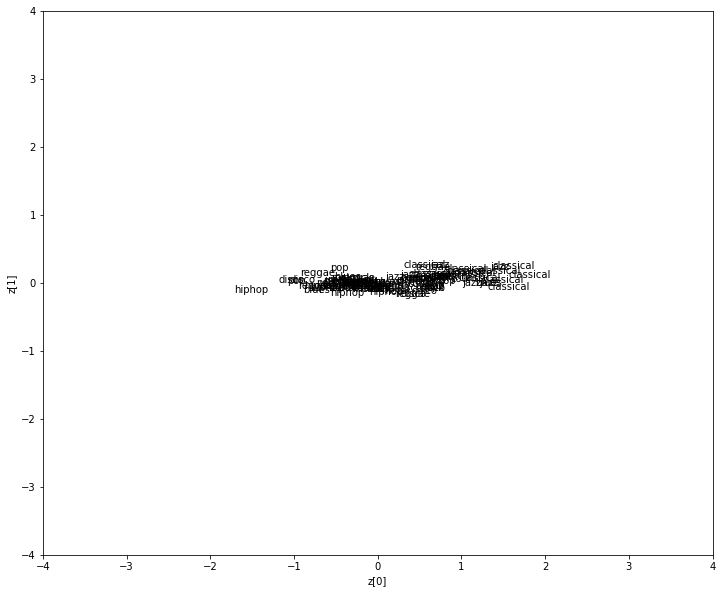

latent_dim = 9
Epoch 1/50
7/7 [==============================] - 1s 55ms/step - loss: 50.4661 - val_loss: 38.5724
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 30.8912 - val_loss: 22.4120
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 19.5270 - val_loss: 16.8309
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 15.7946 - val_loss: 14.6120
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 14.3480 - val_loss: 13.9458
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 13.8075 - val_loss: 13.5718
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 13.4621 - val_loss: 13.2706
Epoch 8/50
7/7 [==============================] - 0s 26ms/step - loss: 12.8817 - val_loss: 12.6499
Epoch 9/50
7/7 [==============================] - 0s 27ms/step - loss: 12.5879 - val_loss: 11.8790
Epoch 10/50
7/7 [==============================] - 0s 26ms/step - loss: 12.3472 - val_loss: 11

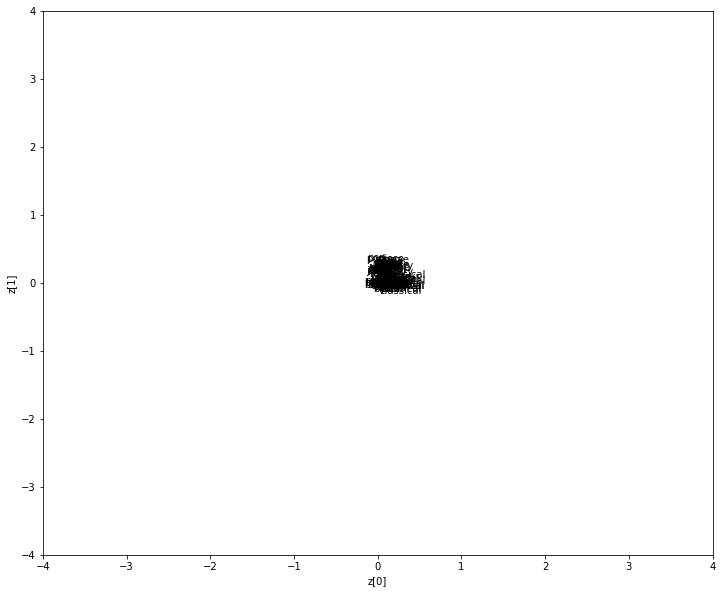

latent_dim = 10
Epoch 1/50
7/7 [==============================] - 1s 52ms/step - loss: 50.7539 - val_loss: 38.6470
Epoch 2/50
7/7 [==============================] - 0s 26ms/step - loss: 30.5332 - val_loss: 23.1062
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 19.6519 - val_loss: 16.3089
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 15.4961 - val_loss: 14.0937
Epoch 5/50
7/7 [==============================] - 0s 27ms/step - loss: 14.1797 - val_loss: 13.6554
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 13.3581 - val_loss: 13.0248
Epoch 7/50
7/7 [==============================] - 0s 30ms/step - loss: 12.9858 - val_loss: 12.2333
Epoch 8/50
7/7 [==============================] - 0s 26ms/step - loss: 12.3416 - val_loss: 12.0229
Epoch 9/50
7/7 [==============================] - 0s 27ms/step - loss: 11.9757 - val_loss: 11.6973
Epoch 10/50
7/7 [==============================] - 0s 26ms/step - loss: 11.5972 - val_loss: 1

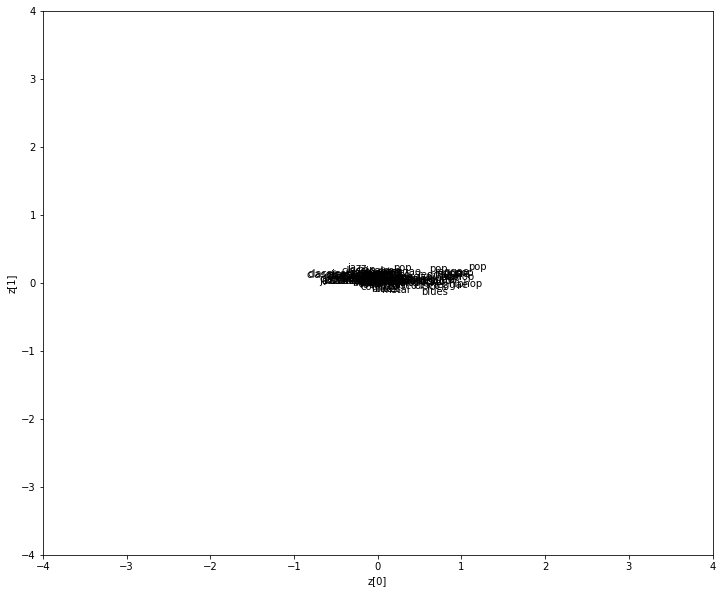

latent_dim = 11
Epoch 1/50
7/7 [==============================] - 1s 56ms/step - loss: 50.9231 - val_loss: 38.4292
Epoch 2/50
7/7 [==============================] - 0s 29ms/step - loss: 31.1580 - val_loss: 22.5385
Epoch 3/50
7/7 [==============================] - 0s 27ms/step - loss: 20.2296 - val_loss: 16.2519
Epoch 4/50
7/7 [==============================] - 0s 28ms/step - loss: 15.2561 - val_loss: 14.3919
Epoch 5/50
7/7 [==============================] - 0s 26ms/step - loss: 13.7921 - val_loss: 13.0057
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 12.8776 - val_loss: 12.4874
Epoch 7/50
7/7 [==============================] - 0s 27ms/step - loss: 12.3474 - val_loss: 12.0129
Epoch 8/50
7/7 [==============================] - 0s 26ms/step - loss: 11.8809 - val_loss: 11.5532
Epoch 9/50
7/7 [==============================] - 0s 28ms/step - loss: 11.8897 - val_loss: 11.2217
Epoch 10/50
7/7 [==============================] - 0s 27ms/step - loss: 11.3429 - val_loss: 1

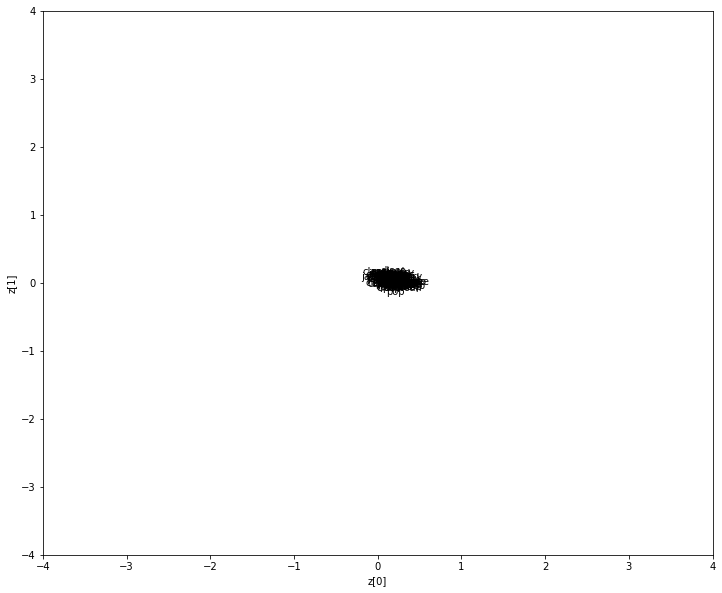

latent_dim = 12
Epoch 1/50
7/7 [==============================] - 1s 55ms/step - loss: 49.3574 - val_loss: 36.6744
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 29.0318 - val_loss: 21.2351
Epoch 3/50
7/7 [==============================] - 0s 27ms/step - loss: 18.6346 - val_loss: 15.5506
Epoch 4/50
7/7 [==============================] - 0s 26ms/step - loss: 14.8173 - val_loss: 14.0870
Epoch 5/50
7/7 [==============================] - 0s 27ms/step - loss: 13.8036 - val_loss: 13.2015
Epoch 6/50
7/7 [==============================] - 0s 26ms/step - loss: 12.9350 - val_loss: 12.9073
Epoch 7/50
7/7 [==============================] - 0s 26ms/step - loss: 12.4028 - val_loss: 11.9524
Epoch 8/50
7/7 [==============================] - 0s 26ms/step - loss: 11.8563 - val_loss: 11.4155
Epoch 9/50
7/7 [==============================] - 0s 27ms/step - loss: 11.6957 - val_loss: 11.4313
Epoch 10/50
7/7 [==============================] - 0s 29ms/step - loss: 11.1545 - val_loss: 1

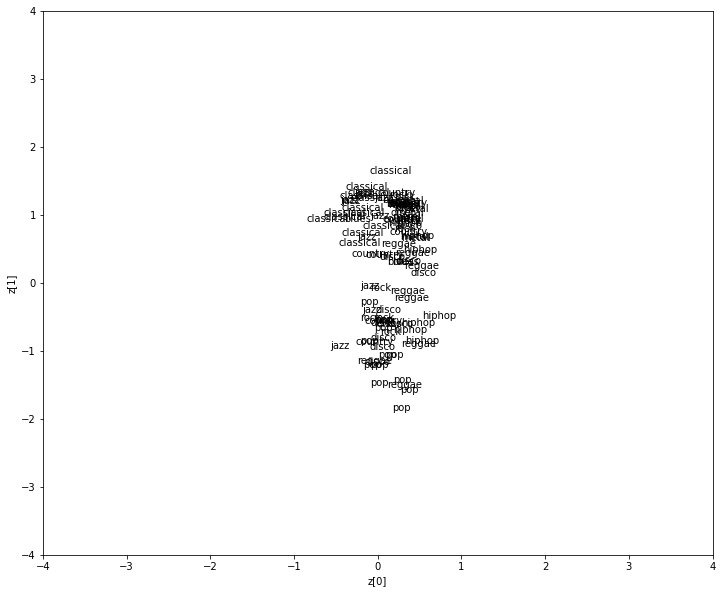

latent_dim = 13
Epoch 1/50
7/7 [==============================] - 1s 53ms/step - loss: 49.6871 - val_loss: 35.7408
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 28.2937 - val_loss: 20.5702
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 18.1893 - val_loss: 15.4375
Epoch 4/50
7/7 [==============================] - 0s 27ms/step - loss: 15.1132 - val_loss: 14.5831
Epoch 5/50
7/7 [==============================] - 0s 28ms/step - loss: 14.1357 - val_loss: 13.6913
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 13.3842 - val_loss: 13.0326
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 12.7040 - val_loss: 12.7444
Epoch 8/50
7/7 [==============================] - 0s 28ms/step - loss: 12.4457 - val_loss: 12.1201
Epoch 9/50
7/7 [==============================] - 0s 28ms/step - loss: 12.2558 - val_loss: 11.4401
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 11.8196 - val_loss: 1

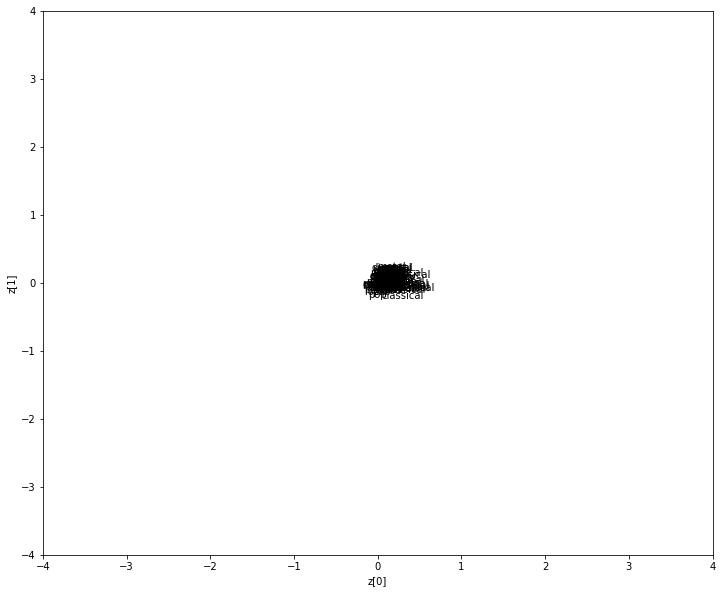

latent_dim = 14
Epoch 1/50
7/7 [==============================] - 1s 52ms/step - loss: 50.5087 - val_loss: 37.1056
Epoch 2/50
7/7 [==============================] - 0s 28ms/step - loss: 29.4424 - val_loss: 21.8062
Epoch 3/50
7/7 [==============================] - 0s 27ms/step - loss: 18.5872 - val_loss: 15.6748
Epoch 4/50
7/7 [==============================] - 0s 27ms/step - loss: 14.7231 - val_loss: 13.6111
Epoch 5/50
7/7 [==============================] - 0s 27ms/step - loss: 13.5221 - val_loss: 12.6679
Epoch 6/50
7/7 [==============================] - 0s 27ms/step - loss: 12.8322 - val_loss: 12.3961
Epoch 7/50
7/7 [==============================] - 0s 27ms/step - loss: 12.3576 - val_loss: 11.9060
Epoch 8/50
7/7 [==============================] - 0s 29ms/step - loss: 11.9652 - val_loss: 11.6505
Epoch 9/50
7/7 [==============================] - 0s 30ms/step - loss: 11.8618 - val_loss: 11.1792
Epoch 10/50
7/7 [==============================] - 0s 27ms/step - loss: 11.4199 - val_loss: 1

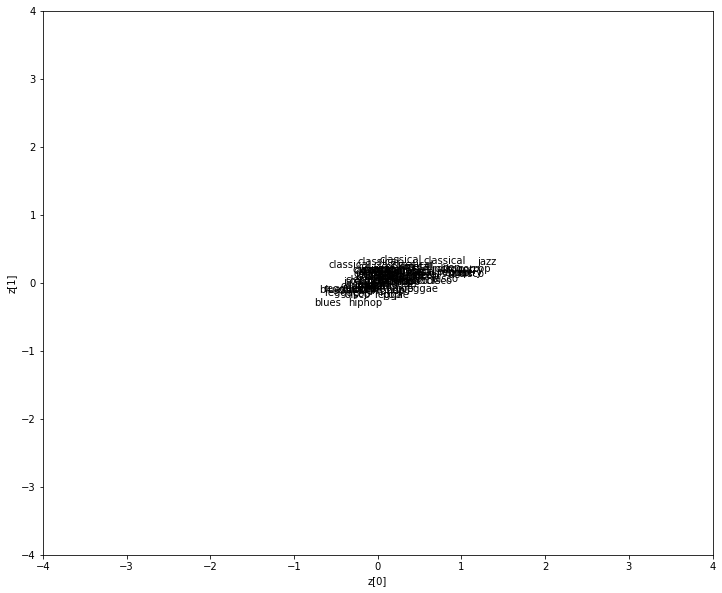

latent_dim = 15
Epoch 1/50
7/7 [==============================] - 1s 51ms/step - loss: 50.8426 - val_loss: 37.4802
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 29.3853 - val_loss: 21.7858
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 18.4038 - val_loss: 15.7979
Epoch 4/50
7/7 [==============================] - 0s 27ms/step - loss: 14.7513 - val_loss: 13.8185
Epoch 5/50
7/7 [==============================] - 0s 28ms/step - loss: 13.5939 - val_loss: 13.0630
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 12.9196 - val_loss: 12.4869
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 12.4544 - val_loss: 11.9299
Epoch 8/50
7/7 [==============================] - 0s 28ms/step - loss: 12.1231 - val_loss: 11.5508
Epoch 9/50
7/7 [==============================] - 0s 27ms/step - loss: 11.5334 - val_loss: 11.3975
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 11.7105 - val_loss: 1

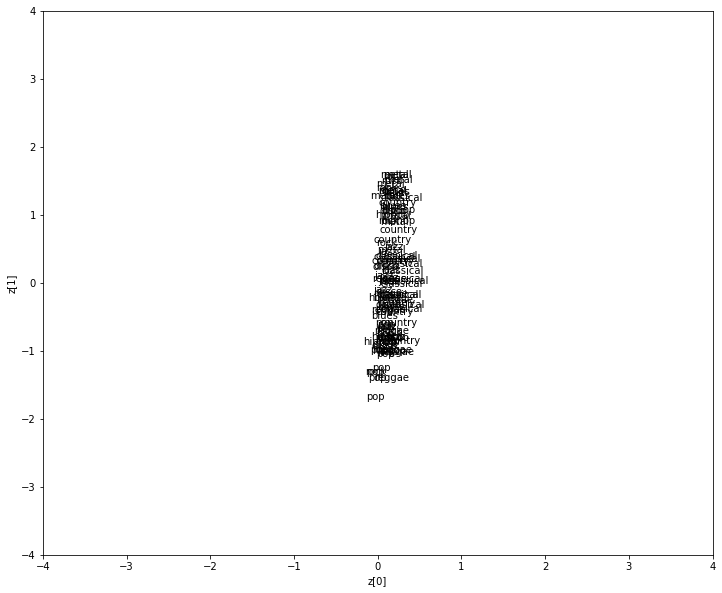

latent_dim = 16
Epoch 1/50
7/7 [==============================] - 1s 56ms/step - loss: 49.5434 - val_loss: 36.5623
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 28.3756 - val_loss: 21.0417
Epoch 3/50
7/7 [==============================] - 0s 28ms/step - loss: 17.8605 - val_loss: 15.5375
Epoch 4/50
7/7 [==============================] - 0s 27ms/step - loss: 14.3900 - val_loss: 13.2927
Epoch 5/50
7/7 [==============================] - 0s 28ms/step - loss: 13.1287 - val_loss: 12.7666
Epoch 6/50
7/7 [==============================] - 0s 32ms/step - loss: 12.8756 - val_loss: 12.1893
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 12.1789 - val_loss: 11.6170
Epoch 8/50
7/7 [==============================] - 0s 29ms/step - loss: 11.6706 - val_loss: 11.5028
Epoch 9/50
7/7 [==============================] - 0s 26ms/step - loss: 11.4959 - val_loss: 11.1264
Epoch 10/50
7/7 [==============================] - 0s 33ms/step - loss: 11.0267 - val_loss: 1

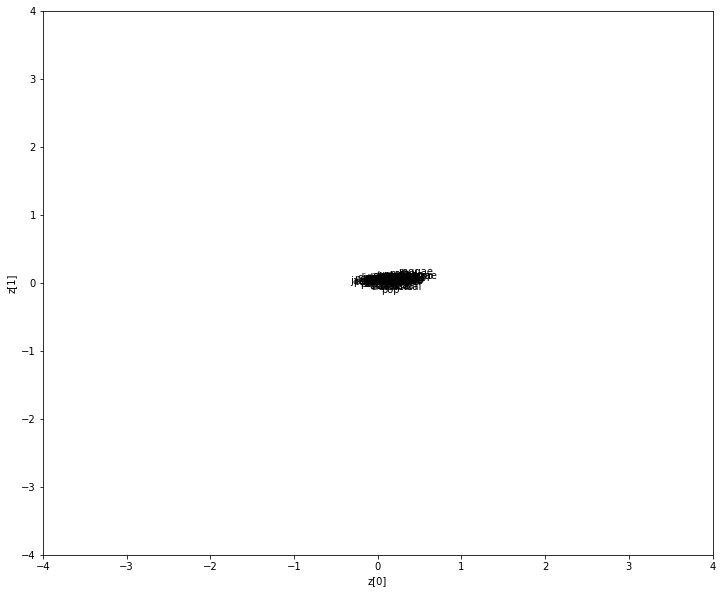

latent_dim = 17
Epoch 1/50
7/7 [==============================] - 1s 64ms/step - loss: 49.5722 - val_loss: 35.6244
Epoch 2/50
7/7 [==============================] - 0s 30ms/step - loss: 28.0422 - val_loss: 20.0948
Epoch 3/50
7/7 [==============================] - 0s 30ms/step - loss: 17.7208 - val_loss: 15.4499
Epoch 4/50
7/7 [==============================] - 0s 29ms/step - loss: 14.4201 - val_loss: 13.6969
Epoch 5/50
7/7 [==============================] - 0s 29ms/step - loss: 13.4083 - val_loss: 12.7862
Epoch 6/50
7/7 [==============================] - 0s 29ms/step - loss: 12.8056 - val_loss: 12.3602
Epoch 7/50
7/7 [==============================] - 0s 28ms/step - loss: 12.4416 - val_loss: 11.9629
Epoch 8/50
7/7 [==============================] - 0s 28ms/step - loss: 11.8820 - val_loss: 11.4808
Epoch 9/50
7/7 [==============================] - 0s 28ms/step - loss: 11.6407 - val_loss: 11.3551
Epoch 10/50
7/7 [==============================] - 0s 30ms/step - loss: 11.4471 - val_loss: 1

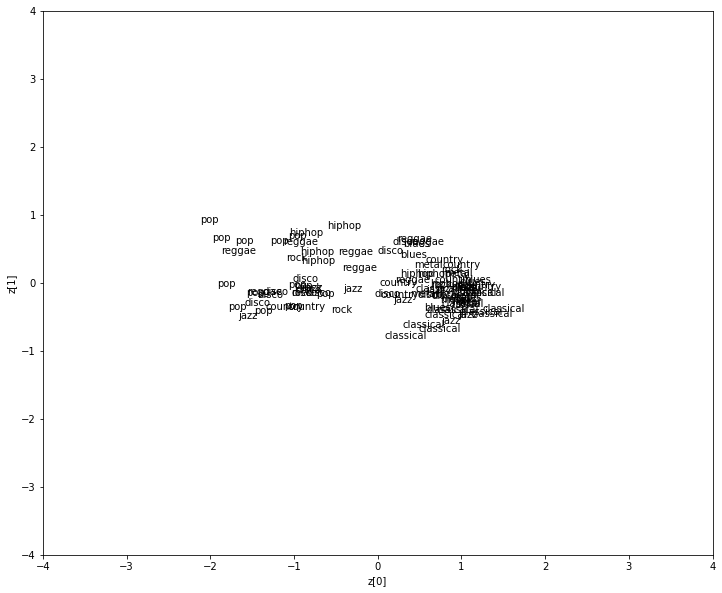

latent_dim = 18
Epoch 1/50
7/7 [==============================] - 2s 81ms/step - loss: 49.5934 - val_loss: 35.8175
Epoch 2/50
7/7 [==============================] - 0s 47ms/step - loss: 27.9521 - val_loss: 20.5256
Epoch 3/50
7/7 [==============================] - 0s 40ms/step - loss: 17.7136 - val_loss: 15.1723
Epoch 4/50
7/7 [==============================] - 0s 44ms/step - loss: 14.4071 - val_loss: 13.4101
Epoch 5/50
7/7 [==============================] - 0s 44ms/step - loss: 13.4337 - val_loss: 13.0029
Epoch 6/50
7/7 [==============================] - 0s 45ms/step - loss: 12.8307 - val_loss: 12.3301
Epoch 7/50
7/7 [==============================] - 0s 45ms/step - loss: 12.4167 - val_loss: 11.8928
Epoch 8/50
7/7 [==============================] - 0s 42ms/step - loss: 11.7660 - val_loss: 11.4585
Epoch 9/50
7/7 [==============================] - 0s 42ms/step - loss: 11.3562 - val_loss: 11.3850
Epoch 10/50
7/7 [==============================] - 0s 44ms/step - loss: 11.1776 - val_loss: 1

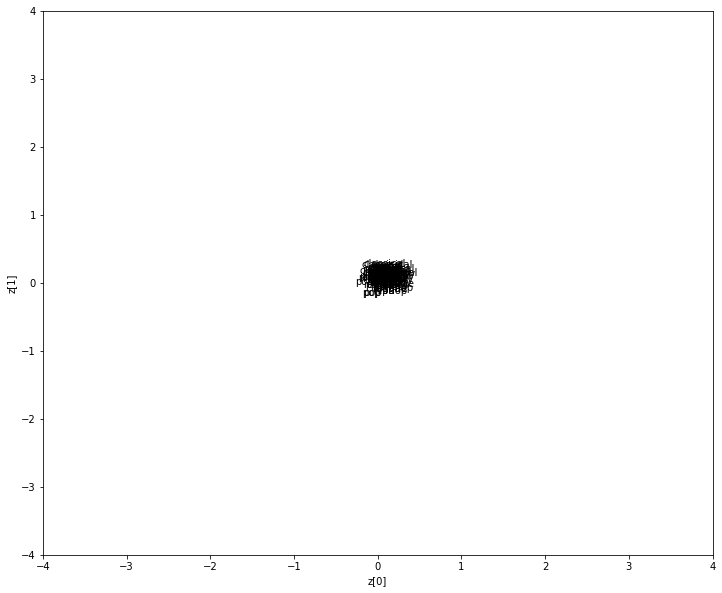

latent_dim = 19
Epoch 1/50
7/7 [==============================] - 1s 54ms/step - loss: 49.3189 - val_loss: 34.8157
Epoch 2/50
7/7 [==============================] - 0s 27ms/step - loss: 27.4694 - val_loss: 19.9249
Epoch 3/50
7/7 [==============================] - 0s 29ms/step - loss: 17.4372 - val_loss: 14.9650
Epoch 4/50
7/7 [==============================] - 0s 30ms/step - loss: 14.3552 - val_loss: 13.2079
Epoch 5/50
7/7 [==============================] - 0s 33ms/step - loss: 13.5171 - val_loss: 13.0050
Epoch 6/50
7/7 [==============================] - 0s 30ms/step - loss: 12.8692 - val_loss: 12.3147
Epoch 7/50
7/7 [==============================] - 0s 32ms/step - loss: 12.3991 - val_loss: 11.8278
Epoch 8/50
7/7 [==============================] - 0s 32ms/step - loss: 12.0025 - val_loss: 11.4894
Epoch 9/50
7/7 [==============================] - 0s 29ms/step - loss: 11.9812 - val_loss: 11.2850
Epoch 10/50
7/7 [==============================] - 0s 28ms/step - loss: 11.4742 - val_loss: 1

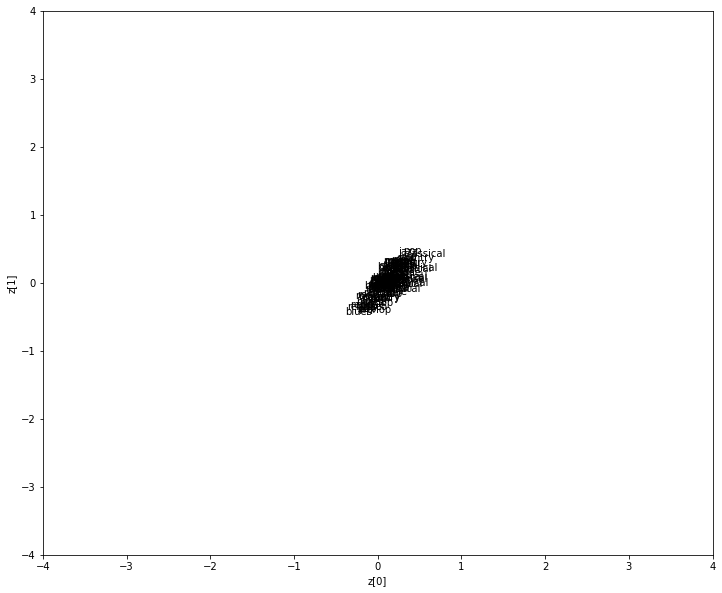

latent_dim = 20
Epoch 1/50
7/7 [==============================] - 2s 100ms/step - loss: 48.7605 - val_loss: 34.3034
Epoch 2/50
7/7 [==============================] - 0s 43ms/step - loss: 26.5888 - val_loss: 19.1820
Epoch 3/50
7/7 [==============================] - 0s 44ms/step - loss: 17.1380 - val_loss: 14.8223
Epoch 4/50
7/7 [==============================] - 0s 43ms/step - loss: 14.1489 - val_loss: 13.6048
Epoch 5/50
7/7 [==============================] - 0s 42ms/step - loss: 13.1938 - val_loss: 12.7371
Epoch 6/50
7/7 [==============================] - 0s 43ms/step - loss: 12.8093 - val_loss: 12.2432
Epoch 7/50
7/7 [==============================] - 0s 46ms/step - loss: 12.3081 - val_loss: 11.7983
Epoch 8/50
7/7 [==============================] - 0s 46ms/step - loss: 12.1763 - val_loss: 11.4699
Epoch 9/50
7/7 [==============================] - 0s 45ms/step - loss: 11.5718 - val_loss: 11.1110
Epoch 10/50
7/7 [==============================] - 0s 42ms/step - loss: 11.3479 - val_loss: 

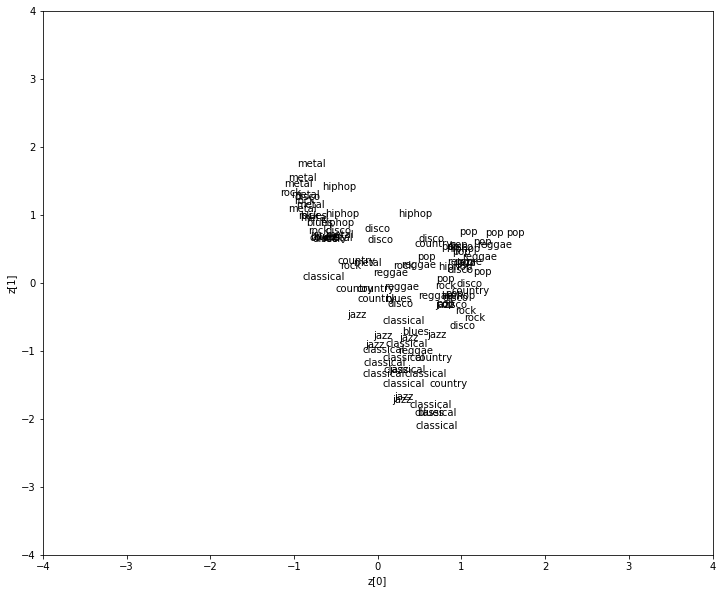

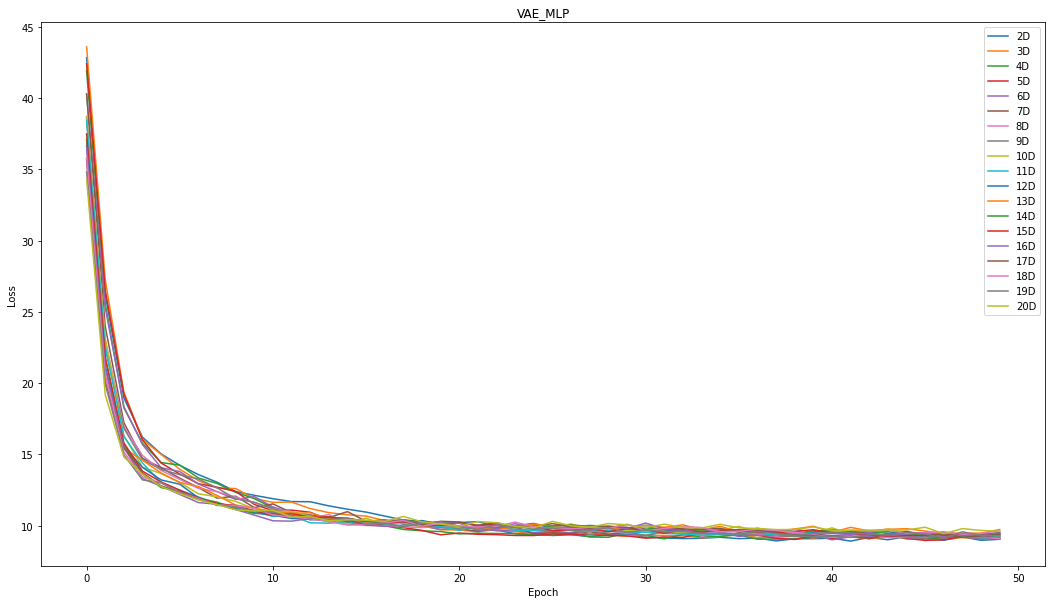

In [ ]:
# 2 ~ 20차원
hist = []
for i in range(2, 21):
  print('latent_dim =', i)
  history = vae_mlp(i)
  hist.append(history)
  print("="*100)

# VAL_LOSS 시각화
plt.figure(figsize=(18,10))
for i in range(len(hist)):
  plt.plot(hist[i].history['val_loss'])
plt.title('VAE_MLP')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend([str(i)+'D' for i in range(2, 21)], loc='upper right')
plt.show()

### cf) 3차원 상 scatterplot

In [ ]:
def scatterplot_3d(angle1=None, angle2=None):
  encoder, decoder = models
  x_test, y_test = data
  model_name="vae_mlp_model"
  xmin = ymin = -5
  xmax = ymax = +5
  zmin = -0.5
  zmax = 0.5
  os.makedirs(model_name, exist_ok=True)

  filename = os.path.join(model_name, "vae_mean.png")
  z, _, _ = encoder.predict(x_test,
                            batch_size=batch_size)
  plt.figure(figsize=(15, 15))

  # axes x and y ranges
  axes = plt.gca(projection='3d')
  axes.set_xlim([xmin,xmax])
  axes.set_ylim([ymin,ymax])
  axes.set_zlim([zmin,zmax])
  if angle1 != None and angle2 != None:
    axes.view_init(angle1, angle2)

  # subsample to reduce density of points on the plot
  z = z[0::2]
  y_test = y_test[0::2]

  color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
  genre = list(y_test.unique())
  for i, label in enumerate(y_test): #plot each point + it's index as text above
    c = 0
    for j in range(len(genre)):
      if label == genre[j]:
        c = j
    axes.scatter(z[i,0], z[i,1], z[i,2], marker="") 
    axes.text(z[i,0], z[i,1], z[i,2], '%s' % (label), c=color[c], zorder=1) 

  axes.set_xlabel('z[0]')
  axes.set_ylabel('z[1]')
  axes.set_zlabel('z[2]')
  plt.savefig(filename)
  plt.show()

  filename = os.path.join(model_name, "digits_over_latent.png")

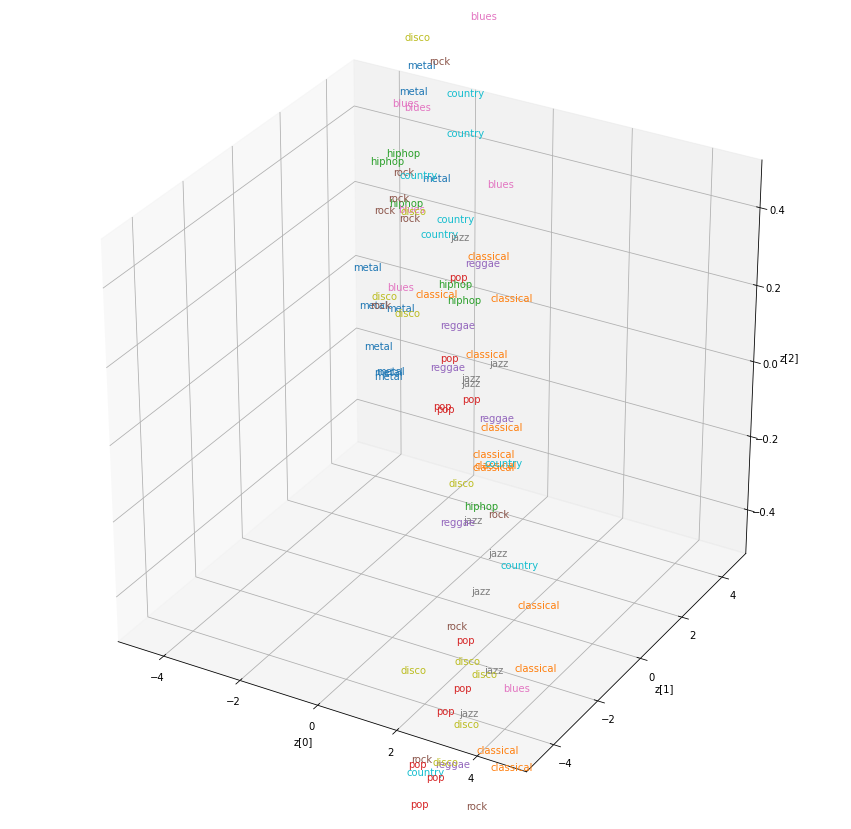

In [ ]:
scatterplot_3d()